# Project Title: Academic Article Topic Modeling Unsupervised Learning Algorithm Comparison

**Author: Tyler Kinkade**

**Project Repository: https://github.com/tyknkd/academic-article-topic-modeling**

# Project Topic Overview

The capability to automatically locate academic research articles by topic can aid researchers and students in finding relevant information and saving hours of sifting through irrelevant articles. Several unsupervised machine learning matrix decomposition algorithms can be applied to this **topic modeling** task, including **latent semantic analysis (LSA), non-negative matrix factorization (NMF), and latent Dirichlet allocation (LDA)** (Jurafsky & Martin, 2025).

However, academic article topics are not necessarily evenly distributed. Some scientific fields might have more publications than others. That is, the topic distribution is imbalanced, which can be a problem for machine learning algorithms. Therefore, the **goal** of this project is to compare the effectiveness of these algorithms in the topic modeling of real-world, imbalanced academic article abstracts.

To achieve this aim, I first perform exploratory data analysis, followed by model tuning and training. Next, I present the results and analysis, followed by a discussion and conclusion.

# Exploratory Data Analysis

In this section, I first present the data's provenance and basic structure. Next, I examine the academic disciplines and subfields (i.e., classes) represented in the data. Next, I explore the article abstracts (i.e., texts) and transform them for modeling. This is followed by exploratory clustering and a summary of the section.

## Data Provenance

The **publicly-sourced, labeled, textual [data](https://huggingface.co/datasets/TimSchopf/arxiv_categories)** comes from a study (Schopf et al., 2024) examining the efficacy of a pretrained neural-network language model for few shot multi-label classification of scientific research article abstracts from Cornell University's public [arXiv](https://arxiv.org/) repository. The data is already split into training, validation, and test sets of 163,168, 20,396, and 20,397 abstracts and associated metadata (ID, title, research categories, and date) respectively in an 80:10:10 ratio via stratified sampling to retain the same relative class frequencies across sets.

In [ ]:
# Load libraries
from collections import Counter, namedtuple
import gc
import itertools
import pandas as pd
import pickle
import pingouin as pg
import math
import numpy as np
import matplotlib.pylab as plt
import re
from scipy.sparse import csr_matrix, issparse
import seaborn as sns
import spacy
import statsmodels.stats.api as sms
from sklearn.base import BaseEstimator, ClassifierMixin, clone, TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import resample
import time


In [ ]:
# Environment settings
data_path = 'data/'
image_path = 'images/'
pickle_path = 'data/'
n_process = 6

In [ ]:
# Load spaCy language model
!python3 -m spacy download en_core_web_sm

In [ ]:
# Load and inspect data
Data = namedtuple('Data', ['train', 'validation', 'test'])
data = Data(
    pd.read_parquet(data_path + 'train-00000-of-00001.parquet'),
    pd.read_parquet(data_path + 'validation-00000-of-00001.parquet'),
    pd.read_parquet(data_path + 'test-00000-of-00001.parquet')
)

print('Training data set:')
print(data.train.info())
print('\nValidation data set:')
print(data.validation.info())
print('\nTest data set:')
print(data.test.info())

Training data set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163168 entries, 0 to 163167
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   id             163168 non-null  object             
 1   title          163168 non-null  object             
 2   abstract       163168 non-null  object             
 3   categories     163168 non-null  object             
 4   creation_date  163168 non-null  datetime64[us, UTC]
dtypes: datetime64[us, UTC](1), object(4)
memory usage: 6.2+ MB
None

Validation data set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20396 entries, 0 to 20395
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   id             20396 non-null  object             
 1   title          20396 non-null  object             
 2   abstract       20396 non-null  object       

In [ ]:
# Inspect first 5 entries
data.train.head()

,id,title,abstract,categories,creation_date
0,2204.14117,A Comparative Study of Meter Detection Methods...,In order to read meter values from a camera on...,[Computer Science Archive->cs.CV],2022-04-24 13:59:57+00:00
1,2305.19887,The Markov chain embedding problem in a low ju...,We consider the problem of finding the transit...,[Mathematics Archive->math.PR],2023-05-31 14:24:25+00:00
2,0910.5857,Chaotic Transport and Chronology of Complex As...,We present a transport model that describes th...,[Physics Archive->astro-ph->astro-ph.EP],2009-10-30 12:34:26+00:00
3,1801.10207,FITing-Tree: A Data-aware Index Structure,Index structures are one of the most important...,[Computer Science Archive->cs.DB],2018-01-30 20:22:53+00:00
4,0803.0849,The Universal Cardinal Ordering of Fixed Points,"We present the theorem which determines, by a ...",[Physics Archive->nlin->nlin.CD],2008-03-06 12:55:48+00:00


## Classes

The target classes are lists of [arXiv tags](https://arxiv.org/category_taxonomy) which indicate the general discipline (computer science, economics, electrical engineering and systems science, mathematics, physics, quantitative biology, quantitative finance, or statistics) and the sub-fields (e.g., AI, hardware architecture, econometrics, astrophysics, etc.). Some entries have more than one tag, and these tags can span more than one discipline (e.g., both computer science and electrial engineering). Altogether there are 130 distinct tags represented in the combined data set. The following table describes each possible arXiv tag.

In [ ]:
# View arXiv tags and descriptions
descriptions = pd.read_parquet(data_path + 'arxiv_category_descriptions-00000-of-00001.parquet')
descriptions.tail()

,tag,name,description
152,stat.CO,Computation,Computation in statistics focuses on Algorithm...
153,stat.ME,Methodology,"Methodology in statistics focuses on Design, S..."
154,stat.ML,Machine Learning,Machine learning in statistics focuses on mach...
155,stat.OT,Other Statistics,Other statistics focuses on works that are eit...
156,stat.TH,Statistics Theory,"Statistics theory focuses on applied, computat..."


In the calculation below, we see that the same 130 unique tags are represented in each of the data sets.

In [ ]:
# Count unique tags
Tagsets = namedtuple('Tagsets', ['train', 'validation', 'test'])
tagsets = Tagsets(set(), set(), set())

for df, tagset in zip(data, tagsets):
    df.categories.apply(lambda tags: [tagset.add(tag) for tag in tags])

print('Number of Unique Tags:')
print(f'  Training set: {len(tagsets.train)}')
print(f'  Validation set: {len(tagsets.validation)}')
print(f'  Test set: {len(tagsets.test)}')
print(f'  Combined: {len(tagsets.train | tagsets.validation | tagsets.test)}')

Number of Unique Tags:
  Training set: 130
  Validation set: 130
  Test set: 130
  Combined: 130


The histogram below, shows the counts for the number of tags per article. The articles have no more than four tags, and the vast majority have only one tag.

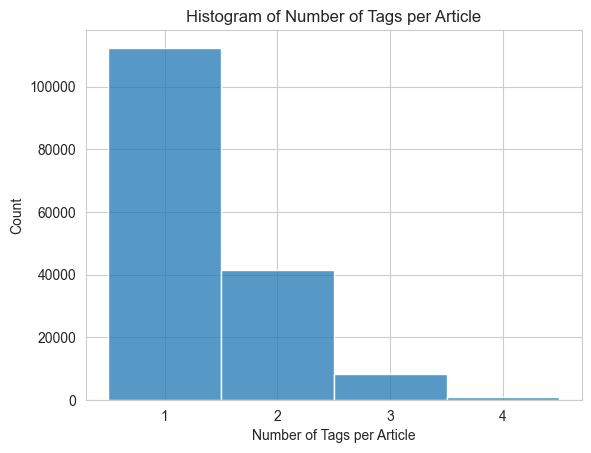

In [ ]:
# Number of tags per article
def plot_histogram(feature: pd.Series, label: str) -> plt.Axes:
    '''
    Histogram of number of items in lists for feature per article
    '''
    counts = feature.apply(lambda x: x.size)
    max_count = counts.unique().size
    sns.set_style('whitegrid')
    ax = sns.histplot(counts, discrete = True)
    ax.set_xticks(range(1, max_count + 1))
    ax.set(title = f'Histogram of Number of {label} per Article',
        xlabel = f'Number of {label} per Article')
    return ax

plot_histogram(data.train.categories, 'Tags');
plt.savefig(image_path + 'tags_article_histogram.png', dpi = 300, bbox_inches = 'tight')

The example below shows that the articles can have multiple tags from different disciplines (in this particular case, computer science and electrical engineering).

In [ ]:
# Category tag examples
data.train.categories[37]

array(['Computer Science Archive->cs.CV',
       'Electrical Engineering and Systems Science Archive->eess.IV'],
      dtype=object)

To determine the frequency of such multidisciplinary papers, I extract the general disciplines and subfields from the tag strings.

In [ ]:
# Separate categories into lists of main disciplines and subfields
# and identify most common discipline

def extract_fields(tags: list) -> list:
    '''
    Separate list of tags into two separate sets
    of disciplines and subfields,
    and identify most common discipline
    '''
    disciplines = list()
    subfields = set()
    for tag in tags:
        labels = re.split('->', tag)
        discipline = re.sub(' Archive', '', labels[0])
        if discipline == 'Electrical Engineering and Systems Science':
            discipline = 'Elec. Eng. & Sys. Sci.'
        disciplines.append(discipline)
        subfields.add(labels[-1])
    disciplines = Counter(disciplines)
    main_discipline = disciplines.most_common(1)[0][0]
    return [main_discipline, set(disciplines.keys()), subfields]

for df in data:
    df[['discipline', 'disciplines', 'subfields']] = df.categories.apply(extract_fields).to_list()
    df.disciplines = df.disciplines.apply(lambda set: np.array(list(set)))
    df.subfields = df.subfields.apply(lambda set: np.array(list(set)))

# View previous example
data.train.iloc[37]

id                                                      2112.14022
title                Towards Low Light Enhancement with RAW Images
abstract         In this paper, we make the first benchmark eff...
categories       [Computer Science Archive->cs.CV, Electrical E...
creation_date                            2021-12-28 07:27:51+00:00
discipline                                        Computer Science
disciplines             [Elec. Eng. & Sys. Sci., Computer Science]
subfields                                         [cs.CV, eess.IV]
Name: 37, dtype: object

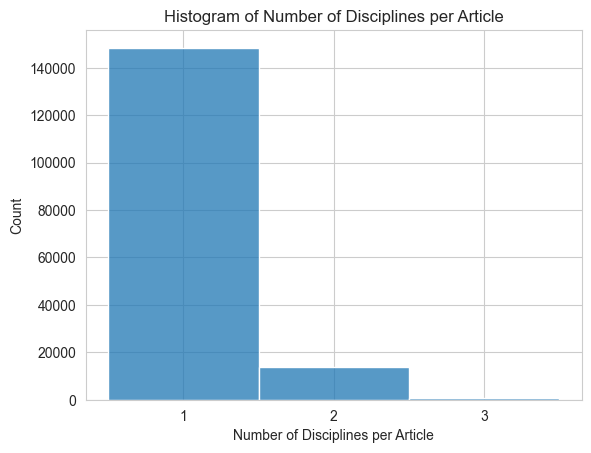

In [ ]:
# Number of disciplines per article
plot_histogram(data.train.disciplines, 'Disciplines');
plt.savefig(image_path + 'disciplines_article_histogram.png', dpi = 300, bbox_inches = 'tight')

The histogram above shows that less than 20,000 of the articles are multidisciplinary. Taken together with the fact that there were over 45,000 articles with multiple tags, we can see that the majority of those articles were not multidisciplinary. That is, their multiple tags were within the same discipline.

### Balance

Next, I examine the relative frequency of the classes.

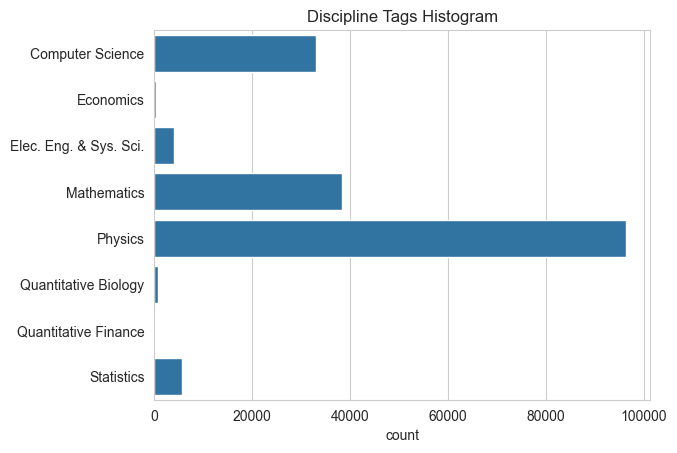

In [ ]:
# Histogram of discipline tags
def tags_histogram(feature: pd.Series, label: str, figheight: int = None) -> plt.Axes:
    y = np.sort(np.concatenate(tuple(feature.to_numpy())))
    sns.set_style('whitegrid')
    ax = sns.countplot(y = y)
    ax.set(title = f'{label} Tags Histogram')
    if figheight is not None:
        ax.figure.set_figheight(figheight)
    return ax

tags_histogram(data.train.disciplines, 'Discipline');
plt.savefig(image_path + 'discipline_tags_histogram.png', dpi = 300, bbox_inches = 'tight')

The above histogram shows that the vast majority of article tags are within the physics discipline, followed by mathematics and computer science. The smallest number of article tags are within the quantitative finance discipline.

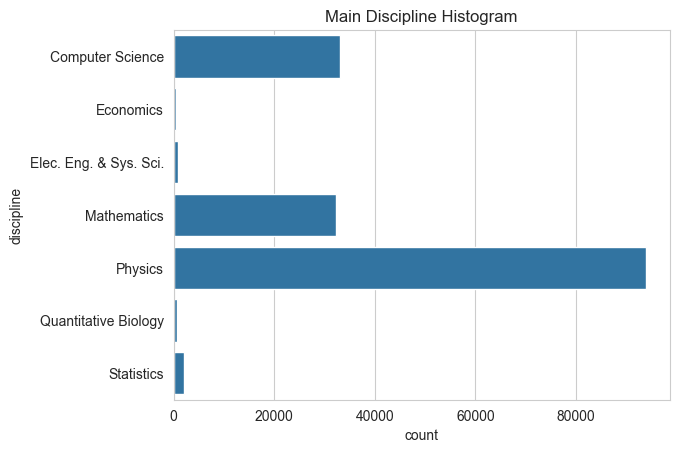

In [ ]:
# Histogram of disciplines
def main_discipline_histogram(discipline: pd.Series) -> plt.Axes:
    sns.set_style('whitegrid')
    ax = sns.countplot(y = discipline, order = np.sort(discipline.unique()))
    ax.set(title = f'Main Discipline Histogram')
    return ax

main_discipline_histogram(data.train.discipline);
plt.savefig(image_path + 'discipline_histogram.png', dpi = 300, bbox_inches = 'tight')

Instead of counting all the discipline tags, the histogram above shows the counts for the predominant discipline tag of each article. (In the case of ties, the first tag in the original data is used.) The number of computer science articles now slightly exceeds the number of mathematics articles, the minority classes have decreased in number, and none have a quantitative finance label for main discipline.

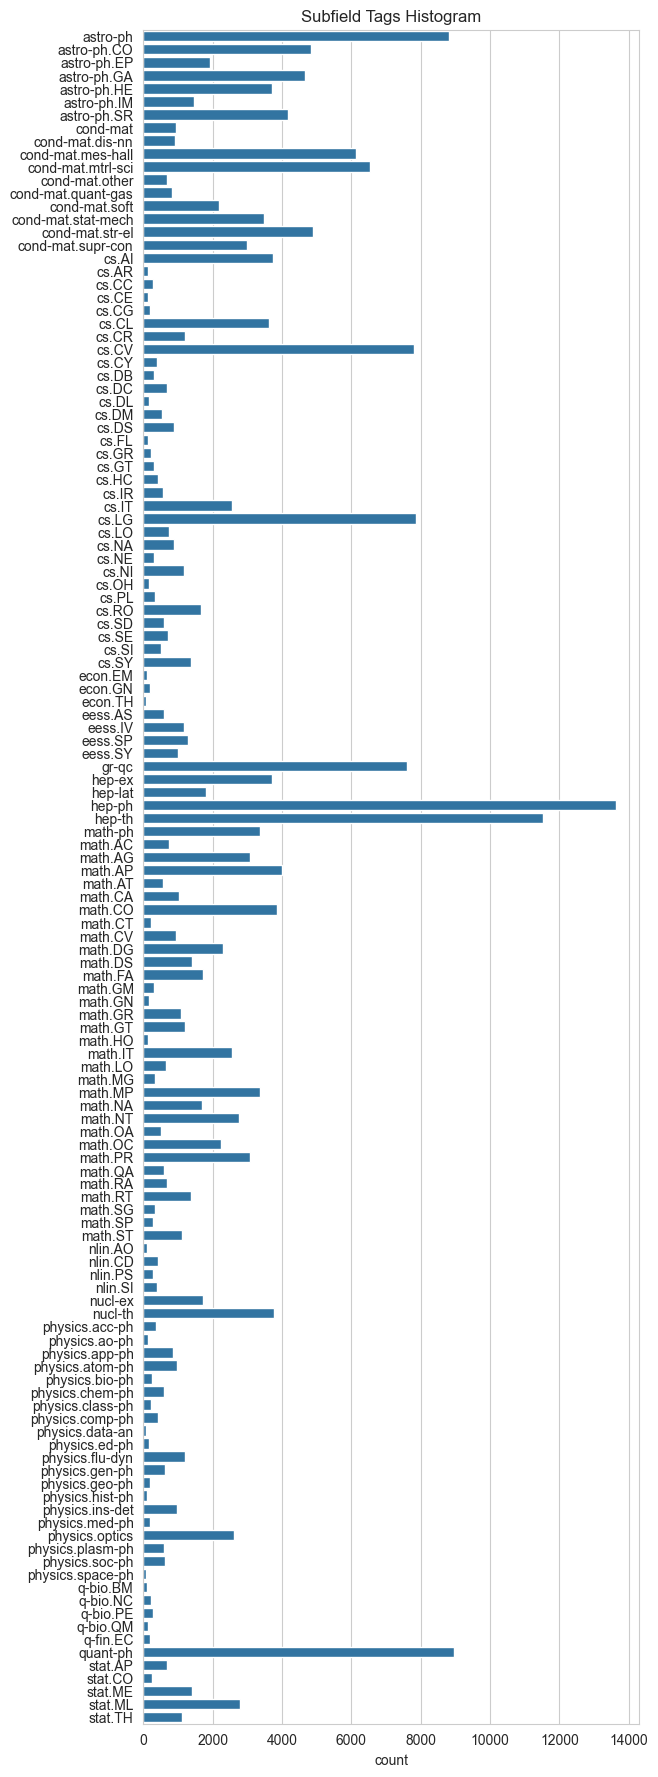

In [ ]:
# Subfield tags histogram
tags_histogram(data.train.subfields, 'Subfield', 22);
plt.savefig(image_path + 'subfield_histogram.png', dpi = 300, bbox_inches = 'tight')

The above histogram shows that the most common article subfield tags are high energy physics phenomenology (`hep-ph`) and theory (`hep-th`), quantum physics (`quant-ph`), and astrophysics (`astro-ph`) in descending order. Clearly, there is a class imbalance in terms of both discipline and subfields, which generally has adverse affects on the performance of machine learning models.

On the other hand, this will most likely be the case for any sample taken from the population of research articles. Some disciplines and subfields will always be represented more than others. Therefore, using sampling techniques to balance the classes will only result in an unrealistic case that cannot reasonably be generalized to unlabeled, unseen data. Furthermore, oversampling methods such as SMOTE do not actually solve the problem of generalization from incomplete information (Provost, 2000; Verzino, 2021). What's more, because the observations have multiple labels, oversampling minority class observations might also mean oversampling observations that also have majority class labels, defeating the purpose. Thus, it is important to identify machine learning algorithms which can handle such imbalanced, real-world data.

Another interesting point is that the only articles within quantitative finance are tagged `q-fin.EC` (i.e., economics). According to the _arXiv Category Taxonomy_ (n.d.), "q-fin.EC is an alias for econ.GN." The following calculation confirms that every article that is tagged `q-fin.EC` is also tagged `econ.GN` and vice versa (i.e., 100% overlap). It is also worth noting that if undersampling were used to balance the discipline classes, 202,121 data samples (i.e., 99% of the data set) would be discarded.

In [ ]:
# Check overlap of econ.GN and q-fin.EC tags
def find_class_matches(df: pd.DataFrame, feature: str, tag: str) -> pd.Index:
    '''
    Return indices where class feature matches tag
    '''
    return df.index[df[feature].apply(lambda x: np.isin(x, tag).sum(axis = 0)) >= 1]

targets = {'econ.GN': set(),
           'q-fin.EC': set()}
for df in data:
    for label, ids in targets.items():
        ids |= set(df.id.values[find_class_matches(df, 'subfields', label)])

combined = set()
print('Number of unique articles in whole data set:')
for label, ids in targets.items():
    print(f'  {label}: {len(ids)} articles')
    combined |= ids
print(f'  Combined: {len(combined)} articles')

Number of unique articles in whole data set:
  econ.GN: 230 articles
  q-fin.EC: 230 articles
  Combined: 230 articles


The following calculation shows that the most under-represented subfield is physics data analysis (`physics.data-an`, 81 articles), followed by theoretical economics (`econ.TH`, 83 articles) and space physics (`physics.space-ph`, 87 articles). There is no overlap between the three classes. Notably, if undersampling were used to balance the 130 subfield classes, 152,638 training data samples (i.e., 93% of the training set) would be discarded.

In [ ]:
# Check numbers of 3 most under-represented subfields
targets = {'econ.TH': set(),
           'physics.data-an': set(),
           'physics.space-ph': set()}

for label, ids in targets.items():
    ids |= set(data.train.id.values[find_class_matches(data.train, 'subfields', label)])

combined = set()
total = 0
print('Number of unique articles in training set:')
for label, ids in targets.items():
    length = len(ids)
    print(f'  {label}: {length} articles')
    combined |= ids
    total += length
print(f'  Combined: {len(combined)} articles (Sum: {total})')

Number of unique articles in training set:
  econ.TH: 83 articles
  physics.data-an: 81 articles
  physics.space-ph: 87 articles
  Combined: 251 articles (Sum: 251)


### Class Correlation

The presence of overlapping tags raises a question: Do correlations exist between the class labels? In other words, can we expect a text with a particular label to also have another label?

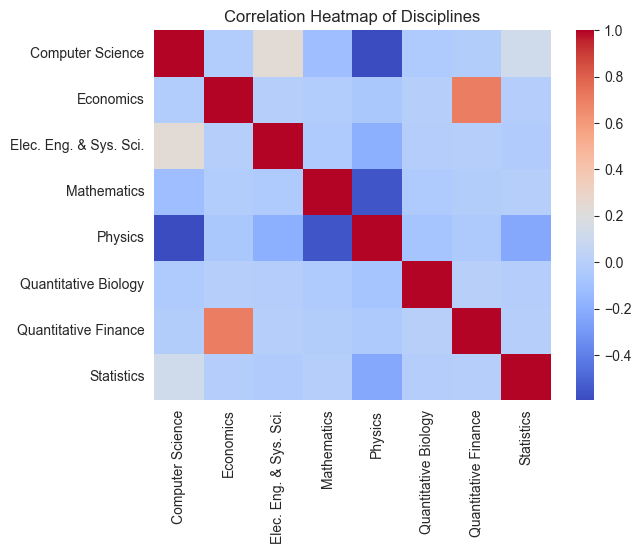

In [ ]:
def class_correlation_heatmap(labels: pd.Series, label_type: str) -> plt.Axes:
    '''
    Heatmap of class correlations
    '''
    mlb = MultiLabelBinarizer(sparse_output = False)
    label_indicators = mlb.fit_transform(labels)
    corr = pd.DataFrame(label_indicators,
                        columns = mlb.classes_).corr()
    sns.set_style('whitegrid')
    ax = sns.heatmap(corr, cmap = 'coolwarm')
    title = f'Correlation Heatmap of {label_type}'
    ax.set(title = title)
    return ax

class_correlation_heatmap(data.train.disciplines, 'Disciplines')
plt.savefig(image_path + 'discipline_heatmap.png', dpi = 300, bbox_inches = 'tight')

The heatmap above shows the correlation coefficients for the discipline labels in the training data. Economics and quantitative finance are positively correlated. This we already found that every quantitative finance article also has an economics tag. There is also a weak positive correlation between computer science and electrical engineering. We also see that physics articles are unlikely to also have computer science or mathematics tags (and vice versa).

## Texts

Next, I examine, clean, and transform the text data.

### Word Count

Word counts reveal some interesting facts about the texts, including the presence of missing data.

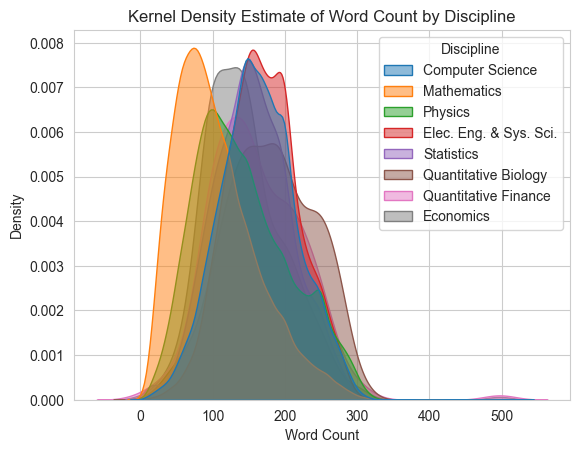

In [ ]:
# Approximate word counts of abstracts
word_counts = data.train.abstract.str.split().str.len()

def word_count_kde_plot(word_counts: pd.Series, labels: pd.Series) -> plt.Axes:
    '''
    Kernel density estimate plot of word count by discipline
    '''
    word_counts_long = []
    labels_long = []
    for count, labels in zip(word_counts, labels.values):
        for label in labels:
            word_counts_long.append(count)
            labels_long.append(label)
    word_count_df = pd.DataFrame({'Discipline': labels_long,
                                'Word Count': word_counts_long})
    ax = sns.kdeplot(data = word_count_df, x = 'Word Count', hue = 'Discipline',
                    fill = True, common_norm = False, alpha = 0.5,
                    linewidth = 1)
    ax.set(title = 'Kernel Density Estimate of Word Count by Discipline');

word_count_kde_plot(word_counts, data.train.disciplines);
plt.savefig(image_path + 'discipline_word_count_kde.png', dpi = 300, bbox_inches = 'tight')

In the kernel density estimate (KDE) plot of word count by discipline, we can see that the distributions of word count are fairly similar, which is to be expected for abstracts, which are usually brief. Mathematics and physics abstracts tend to be shorter than the electrical engineering, computer science, and quantitative biology abstracts. There is also a small second mode of longer economics abstracts around 500 words in length.

### Missing Data

Surprisingly, over 100 of the abstracts are less than 10 words long, and one abstract is only two words.

In [ ]:
print(f'{len(word_counts[word_counts < 10])} abstracts less than 10 words long')
word_counts.describe().round()

111 abstracts less than 10 words long


count    163168.0
mean        138.0
std          64.0
min           2.0
25%          89.0
50%         131.0
75%         182.0
max         525.0
Name: abstract, dtype: float64

In the shortest abstracts listed below, there appear to be various reasons for their concision, such as being withdrawn or revised. These are not missing values per se, but they will generally be difficult to classify based only on the abstract, and there might be similar abstracts in unseen data. In such cases, the titles might offer some clues. Therefore, the titles will be prepended to the abstracts.

In [ ]:
# View articles with abstracts of fewer than 5 words
data.train[['abstract', 'discipline']][word_counts < 5]

,abstract,discipline
38308,revision posted November 1996,Mathematics
67577,See hep-th/0002188,Mathematics
76885,See comment above.,Mathematics
78858,This paper is withdrawn.,Mathematics
99916,withdrawn for revision,Physics
110519,Review on Memristor.,Physics
123980,some errors in equations,Physics
147630,Small errors are corrected,Physics
153212,Final published version.,Physics
156179,We discuss supernear spaces.,Mathematics


In [ ]:
# Prepend titles to abstracts
for df in data:
    df.abstract = df.title + ' ' + df.abstract

# View example
data.train.abstract[35021]

'A survey of 4-manifolds through the eyes of surgery The title says it all.'

### Cleaning

One challenge presented by the text data is the presence of LaTeX mathematical formulas. The following example contains 19 such strings.

In [ ]:
# View sample abstract with 19 LaTeX math strings
sample = data.train.abstract[66]
sample

'Pohozaev identities for a pseudo-relativistic Schr\\"odinger operator and applications In this paper we prove a Pohozaev-type identity for both the problem $(-\\Delta+m^2)^su=f(u)$ in $\\mathbb{R}^N$ and its harmonic extension to $\\mathbb{R}^{N+1}_+$ when $0<s<1$. So, our setting includes the pseudo-relativistic operator $\\sqrt{-\\Delta+m^2}$ and the results showed here are original, to the best of our knowledge. The identity is first obtained in the extension setting and then "translated" into the original problem. In order to do that, we develop a specific Fourier transform theory for the fractionary operator $(-\\Delta+m^2)^s$, which lead us to define a weak solution $u$ of the original problem if the identity \\begin{equation}\\label{defsola}\\int_{\\mathbb{R}^N}(-\\Delta+m^2)^{s/2}u(-\\Delta+m^2)^{s/2}v\\dd x=\\int_{ \\mathbb{R}^N}f(u)v\\dd x\\tag{S}\\end{equation} is satisfied by all $v\\in H^{s}(\\mathbb{R}^N)$. The obtained Pohozaev-type identity is then applied to prove bot

In [ ]:
## RegEx to find all inline LaTex math strings
latex_regex = r'\$+.+?\$+|\\begin\{\w+\}.+?\\end\{\w+\}'
sample_math = re.findall(latex_regex, sample)
print(f'{len(sample_math)} matches')
sample_math

19 matches


['$(-\\Delta+m^2)^su=f(u)$',
 '$\\mathbb{R}^N$',
 '$\\mathbb{R}^{N+1}_+$',
 '$0<s<1$',
 '$\\sqrt{-\\Delta+m^2}$',
 '$(-\\Delta+m^2)^s$',
 '$u$',
 '\\begin{equation}\\label{defsola}\\int_{\\mathbb{R}^N}(-\\Delta+m^2)^{s/2}u(-\\Delta+m^2)^{s/2}v\\dd x=\\int_{ \\mathbb{R}^N}f(u)v\\dd x\\tag{S}\\end{equation}',
 '$v\\in H^{s}(\\mathbb{R}^N)$',
 '$f(u)=|u|^{p-2}u$',
 '$p\\geq 2^{*}_s$',
 '$f$',
 '$\\kappa u^3/(1+u^2)$',
 '$\\kappa$',
 '$(-\\Delta+m^2)^su=f(u)$',
 '$f$',
 '$t^\\alpha$',
 '$\\alpha\\in(1,2^{*}_s-1)$',
 '$t\\ln t$']

If this sample were tokenized as it is, the LaTeX math strings would be split into a large number of dollar signs and math symbols, as demonstrated below.

In [ ]:
# Tokenize sample, remove stop words, punctuation
nlp = spacy.load('en_core_web_sm', exclude = ['ner', 'parser', 'senter'])
doc = nlp(sample)
print([token.text for token in doc if not token.is_stop and not token.is_punct])

['Pohozaev', 'identities', 'pseudo', 'relativistic', 'Schr\\"odinger', 'operator', 'applications', 'paper', 'prove', 'Pohozaev', 'type', 'identity', 'problem', '$', '-\\Delta+m^2)^su', '=', 'f(u)$', '$', '\\mathbb{R}^N$', 'harmonic', 'extension', '$', '\\mathbb{R}^{N+1}_+$', '$', '0', '<', 's<1$.', 'setting', 'includes', 'pseudo', 'relativistic', 'operator', '$', '\\sqrt{-\\Delta+m^2}$', 'results', 'showed', 'original', 'best', 'knowledge', 'identity', 'obtained', 'extension', 'setting', 'translated', 'original', 'problem', 'order', 'develop', 'specific', 'Fourier', 'transform', 'theory', 'fractionary', 'operator', '$', '-\\Delta+m^2)^s$', 'lead', 'define', 'weak', 'solution', '$', 'u$', 'original', 'problem', 'identity', '\\begin{equation}\\label{defsola}\\int_{\\mathbb{R}^N}(-\\Delta+m^2)^{s/2}u(-\\Delta+m^2)^{s/2}v\\dd', 'x=\\int', '\\mathbb{R}^N}f(u)v\\dd', 'x\\tag{S}\\end{equation', 'satisfied', '$', 'v\\in', 'H^{s}(\\mathbb{R}^N)$.', 'obtained', 'Pohozaev', 'type', 'identity', 'a

While it might be helpful to know that there are math formulas present in the abstract, the separate symbols are unlikely to be helpful in distinguishing texts. Therefore, these strings are replaced with the word "formula".

In [ ]:
# Replace LaTeX math strings

def replace_latex(text: str) -> str:
    '''
    Replace LaTeX math strings with `formula`
    '''
    latex_regex = r'\$+.+?\$+|\\begin\{equation\}.+?\\end\{equation\}'
    tag = ' formula '
    text = re.sub(latex_regex, tag, text)
    return text

for df in data:
    df.abstract = df.abstract.apply(replace_latex)

# View lemmatized sample without stop words and punctuation
sample = data.train.abstract[66]
doc = nlp(sample)
print([token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_space])

['pohozaev', 'identity', 'pseudo', 'relativistic', 'schr\\"odinger', 'operator', 'application', 'paper', 'prove', 'Pohozaev', 'type', 'identity', 'problem', 'formula', 'formula', 'harmonic', 'extension', 'formula', 'formula', 'setting', 'include', 'pseudo', 'relativistic', 'operator', 'formula', 'result', 'show', 'original', 'good', 'knowledge', 'identity', 'obtain', 'extension', 'setting', 'translate', 'original', 'problem', 'order', 'develop', 'specific', 'Fourier', 'transform', 'theory', 'fractionary', 'operator', 'formula', 'lead', 'define', 'weak', 'solution', 'formula', 'original', 'problem', 'identity', 'formula', 'satisfied', 'formula', 'obtain', 'Pohozaev', 'type', 'identity', 'apply', 'prove', 'result', 'nonexistence', 'solution', 'case', 'formula', 'formula', 'result', 'existence', 'ground', 'state', 'formula', 'model', 'formula', 'constant', 'formula', 'case', 'apply', 'Nehari', 'Pohozaev', 'manifold', 'introduce', 'D.', 'Ruiz', 'finally', 'prove', 'positive', 'solution', '

As shown above, the LaTeX code has been replaced with the `math_formula` token.

In [ ]:
# Save as pickle object
with open(pickle_path + 'data.pickle', 'wb') as f:
	pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Delete unneeded objects to free memory
del combined, descriptions, doc, sample, sample_math, targets, total, word_counts
c = gc.collect()

### Feature Extraction

To be able to use text to predict topics or classify documents, it is necessary to extract some features from the text. We want to identify words which occur frequently in one class of document, but not in others. This is what the metric term frequency–inverse document frequency (TF-IDF) achieves. It penalizes terms which occur throughout a corpus of texts (Jurafsky & Martin, 2025).

Before computing the TF-IDF vectors, I remove common non-content words (i.e., stop words), such as "the" or "be." I also lemmatize the text so that words such as "wrote" and "written" are represented by their common lemma "write," instead of being treated as separate terms.

In [ ]:
class Lemmatizer:
    '''
    Lemmatize raw texts and remove stop words and punctuation
    '''
    def __init__(self):
        self._nlp = spacy.load('en_core_web_sm',
                               exclude = ['ner', 'parser', 'senter'])

    def transform(self, X: pd.Series) -> np.ndarray:
        '''
        Lemmatize Pandas Series of n texts,
        remove stop words, numbers, whitespace, punctuation,
        and lemmas shorter than 3 characters
        Return n-length array of arrays of lemmas
        '''
        lemmas = np.empty(X.size, dtype = object)
        for i, doc in enumerate(nlp.pipe(X.values, n_process = n_process)):
            tokens = []
            for token in doc:
                if (not token.is_punct
                    and not token.is_space
                    and not token.is_stop
                    and not token.like_num
                    and len(token.lemma_) > 2):
                    tokens.append(token.lemma_.lower())
            lemmas[i] = np.array(tokens)
        return lemmas

Lemmas = namedtuple('Lemmas', ['train', 'validation', 'test'])

lemmas = []
for df in data:
    lemmas.append(Lemmatizer().transform(df.abstract))

lemmas = Lemmas(*tuple(lemmas))

lemmas.train[0]

array(['comparative', 'study', 'meter', 'detection', 'methods',
       'automated', 'infrastructure', 'inspection', 'order', 'read',
       'meter', 'value', 'camera', 'autonomous', 'inspection', 'robot',
       'positional', 'error', 'necessary', 'detect', 'meter', 'region',
       'image', 'study', 'develop', 'shape', 'base', 'texture', 'base',
       'background', 'information', 'base', 'method', 'meter', 'area',
       'detection', 'technique', 'compare', 'effectiveness', 'meter',
       'different', 'shape', 'size', 'result', 'confirm', 'background',
       'information', 'base', 'method', 'detect', 'farth', 'meter',
       'regardless', 'shape', 'number', 'meter', 'stably', 'detect',
       'meter', 'diameter', '40px'], dtype='<U14')

In [ ]:
# Save as pickle object
with open(pickle_path + 'lemmas.pickle', 'wb') as f:
	pickle.dump(lemmas, f, pickle.HIGHEST_PROTOCOL)

Words which occur in fewer than five texts are unlikely to be useful, so these words are removed during TF-IDF vectorization.

In [ ]:
class Vectorizer(TransformerMixin, BaseEstimator):
    '''
    Create TF-IDF vectors from tokenized and lemmatized documents
    '''
    def __init__(self, max_df: float = 0.2, min_df: int = 5,
                 max_features: int = 20000, sublinear_tf = False):
        self.max_df = max_df
        self.min_df = min_df
        self.max_features = max_features
        self.sublinear_tf = sublinear_tf

    def fit(self, X: np.ndarray):
        '''
        Learn vocabulary and inter-document frequency
        from tokenized and lemmatized documents
        '''
        self._vectorizer = TfidfVectorizer(lowercase = False,
                                           analyzer = self._identity,
                                           max_df = self.max_df,
                                           min_df = self.min_df,
                                           max_features = self.max_features,
                                           sublinear_tf = self.sublinear_tf
                                           ).fit(X)
        self._is_fitted = True
        self.vocabulary_ = self._vectorizer.vocabulary_
        self.lemmas_ = self._vectorizer.get_feature_names_out()
        self.n_features_ = self.lemmas_.size
        return self

    def fit_transform(self, X: pd.Series) -> csr_matrix:
        '''
        Return TF-IDF vectors from documents
        '''
        self._vectorizer = TfidfVectorizer(lowercase = False,
                                           analyzer = self._identity,
                                           max_df = self.max_df,
                                           min_df = self.min_df,
                                           max_features = self.max_features,
                                           sublinear_tf = self.sublinear_tf
                                           )
        X_tfidf = self._vectorizer.fit_transform(X)
        self._is_fitted = True
        self.vocabulary_ = self._vectorizer.vocabulary_
        self.lemmas_ = self._vectorizer.get_feature_names_out()
        self.n_features_ = self.lemmas_.size
        return X_tfidf

    def transform(self, X: pd.Series) -> csr_matrix:
        '''
        Return TF-IDF vectors from documents
        using previously fit vocabulary
        '''
        if hasattr(self, '_is_fitted') and self._is_fitted:
            return self._vectorizer.transform(X)
        else:
            return self.fit_transform(X)

    def _identity(self, x):
        return x

def print_sparsity(X):
    '''
    Print sparse matrix type and
    percentage of zero elements in sparse matrix
    '''
    if issparse(X):
        print('Matrix type:', X.getformat())
        sparsity = (1 - X.nnz / np.prod(X.shape)) * 100
        print(f'Sparsity: {sparsity:.2f}%')
    else:
        print('Matrix type: dense')

In [ ]:
# Load pickle objects
# Data = namedtuple('Data', ['train', 'validation', 'test'])
# Lemmas = namedtuple('Lemmas', ['train', 'validation', 'test'])
# with open(pickle_path + 'data.pickle', 'rb') as f:
#     data = pickle.load(f)
# with open(pickle_path + 'lemmas.pickle', 'rb') as f:
#     lemmas = pickle.load(f)

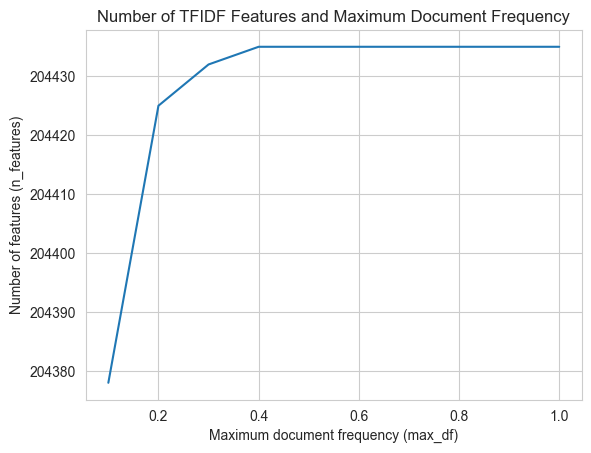

In [ ]:
# Determine point at which vectorizer maximum document
# frequency hyperparameter has an effect on number of features

def max_df_n_features_plot(lemmas: np.ndarray) -> plt.Axes:
    '''
    Plot number of features for TF-IDF vectorizer
    maximum document frequency hyperparameter
    '''
    max_dfs = np.arange(0.1, 1.1, 0.1)
    n_features = []
    for max_df in max_dfs:
        vectorizer = Vectorizer(max_df = max_df,
                                min_df = 1,
                                max_features = None
                                ).fit(lemmas)
        n_features.append(vectorizer.n_features_)

    max_df_label = 'Maximum document frequency (max_df)'
    n_feats_label = 'Number of features (n_features)'
    max_doc_freq = pd.DataFrame({max_df_label: max_dfs})
    n_feats_df = pd.DataFrame({n_feats_label: n_features})
    df = pd.concat([max_doc_freq, n_feats_df], axis = 1)
    sns.set_style('whitegrid')
    ax = sns.lineplot(df, x = max_df_label, y = n_feats_label)
    ax.set(title = 'Number of TFIDF Features and Maximum Document Frequency')
    return ax

max_df_n_features_plot(lemmas.train);
plt.savefig(image_path + 'max_df_n_feats.png', dpi = 300, bbox_inches = 'tight')

The above chart shows the effect of the maximum document frequency (`max_df`) TF-IDF vectorizer hyperparameter on the number of features (i.e., token TF-IDF vectors). Settings above a maximum document frequency of 40% have no impact on the number of features. The inflection point appears to be somewhere around 30%.

In [ ]:
# Vectorize lemmas
vectorizer = Vectorizer(max_df = 0.2, max_features = 20000)
tfidf = vectorizer.fit_transform(lemmas.train)
print_sparsity(tfidf)

Matrix type: csr
Sparsity: 99.73%


The resulting TF-IDF matrix is mostly zeros (99.73% sparse). That is, most of the tokens do not occur in most of the abstracts. In the following subsections, I explore these features.

### Feature Importance

Sorting the sum of TF-IDF scores within a class of documents can reveal salient keywords for that class (Horn et al., 2017).

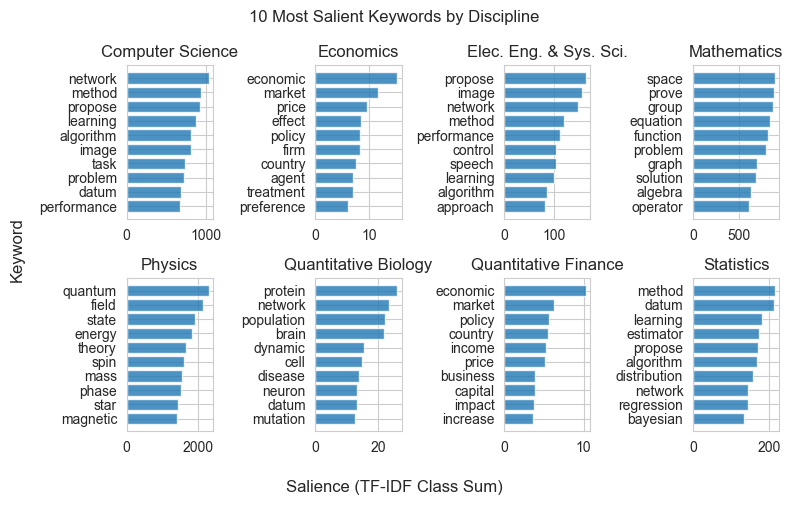

In [ ]:
def salient_class_tokens(tfidf: csr_matrix,
                         labels: pd.Series,
                         tokens: np.ndarray,
                         category: str,
                         n_top_tokens: int = 10) -> tuple:
    '''
    Returns most salient tokens in TF-IDF matrix for specified category,
    their salience (TF-IDF class sum), their indices, and category indices
    '''
    category_idxs = labels.index[labels.apply(lambda x: np.isin(x, category).sum(axis = 0)) >= 1]
    salience = np.array(tfidf[category_idxs].sum(axis = 0))[0]
    sorted_token_idxs = np.argsort(salience)

    top_token_idxs = sorted_token_idxs[-n_top_tokens:]
    top_tokens = tokens[top_token_idxs]
    top_salience = salience[top_token_idxs]

    return top_tokens, top_salience, top_token_idxs, category_idxs

def salient_class_tokens_plot(tfidf: csr_matrix,
                              labels: pd.Series,
                              tokens: np.ndarray,
                              label_type: str,
                              n_top_tokens: int = 10) -> plt.Figure:
    '''
    Returns Matplotlib multi-plot figure of most salient tokens
    in TF-IDF matrix by class in labels
    '''
    all_labels = np.concatenate(tuple(labels.to_numpy()))
    categories = np.unique_values(all_labels)
    n_categories = categories.size
    sns.set_style('whitegrid')
    fig, axs = plt.subplots(ncols = math.ceil(n_categories / 2),
                            nrows = 2,
                            figsize = (n_categories,
                                       math.ceil(n_top_tokens / 2)))
    axs = axs.ravel()
    # Trim extra axes
    for ax in axs[n_categories:]:
        ax.remove()

    title = f'{n_top_tokens} Most Salient Keywords by {label_type}'
    fig.suptitle(title)
    fig.supxlabel('Salience (TF-IDF Class Sum)')
    fig.supylabel('Keyword')
    for category, ax in zip(categories, axs):
        top_tokens, top_salience, _, _ = salient_class_tokens(tfidf,
                                                              labels,
                                                              tokens,
                                                              category,
                                                              n_top_tokens)
        ax.barh(y = top_tokens, width = top_salience, alpha = 0.8)
        ax.set_title(category)
    fig.tight_layout()
    return fig

salient_class_tokens_plot(tfidf, data.train.disciplines,
                          vectorizer.lemmas_, 'Discipline');
plt.savefig(image_path + 'discipline_keywords.png', dpi = 300, bbox_inches = 'tight')

The faceted bar charts above show the ten most salient keywords for each discipline. There is some overlap. For example, "network" is salient for computer science, electrical engineering, quantitative biology, and statistics. There are also differences which make sense intuitively. For example, "protein," "brain," "cell," and "disease" only appear in the top ten for quantitative biology, and "quantum," "energy," "spin," and "mass" are salient only for physics. Tuning the vectorizer hyperparameters further might remove the overlapping keywords.

### Feature Relationships

There are 20,000 TF-IDF token vectors (i.e., features), so it would be impossible to display a single visualization of all $20,000\times 20,000$ pairwise comparisons (and computationally expensive: 24 GB of memory are required to calculate a correlation matrix for the training data). However, it is possible to visualize subsets. For example, we might expect the top keywords within a discipline to correlate with one another but not with the keywords from a different discipline. The following visualizations explore this conjecture.

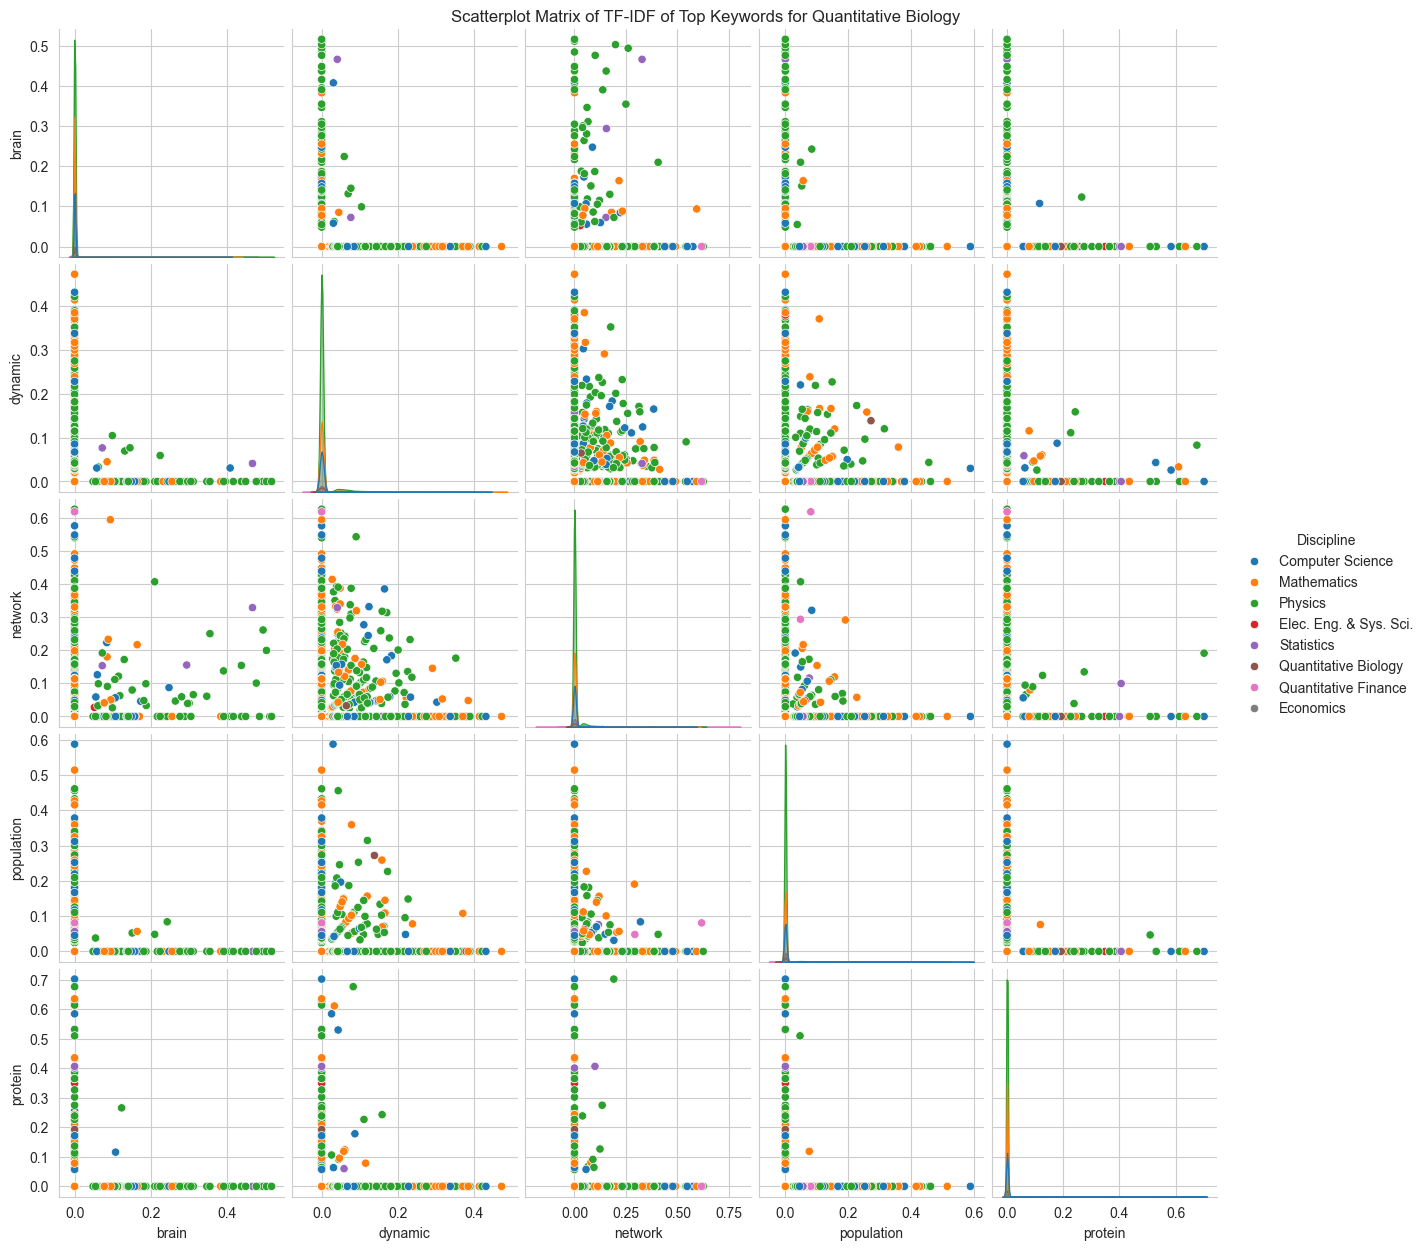

In [ ]:
# Pairwise feature relationships

def salient_multiple_class_tokens(tfidf: csr_matrix,
                                  labels: pd.Series,
                                  tokens: np.ndarray,
                                  categories: list,
                                  n_top_tokens: int = 10):
    '''
    Return salient token and category indices for multiple classes
    '''
    token_idxs = set()
    categories_idxs = set()
    for category in categories:
        _, _, top_token_idxs, category_idxs = salient_class_tokens(tfidf,
                                                                   labels,
                                                                   tokens,
                                                                   category,
                                                                   n_top_tokens)
        token_idxs |= set(top_token_idxs)
        categories_idxs |= set(category_idxs)

    token_idxs = np.sort(np.array(list(token_idxs)))
    categories_idxs = np.sort(np.array(list(categories_idxs)))

    return token_idxs, categories_idxs

def sample_indices(size: int, fraction: float) -> np.ndarray:
    '''
    Return 1-D indices for sample
    '''
    np.random.seed(31)
    replace = True if fraction >= 1 else False
    idxs = np.random.choice(np.arange(size),
                            size = math.ceil(size * fraction),
                            replace = replace)
    idxs.sort()
    return idxs

def token_relationships_plot(tfidf: csr_matrix,
                             labels: pd.Series,
                             tokens: np.ndarray,
                             categories: list,
                             category_type: str = 'Discipline',
                             n_top_tokens: int = 10,
                             kind: str = 'splom') -> plt.Axes:
    '''
    Visualize relationships between salient keywords for specified categories
    '''
    # Get top keyword indices
    token_idxs, categories_idxs = salient_multiple_class_tokens(tfidf,
                                                                labels,
                                                                tokens,
                                                                categories,
                                                                n_top_tokens)

    # Select TF-IDF vectors
    top_token_tfidf = tfidf[:, token_idxs]

    # Plot
    cat_str = ", ".join(categories) if len(categories) > 1 else categories[0]
    ax = None
    sns.set_style('whitegrid')
    if kind == 'splom':
        # Scatterplot matrix

        # Downsample to reduce computation time and simplify plots
        idxs = sample_indices(top_token_tfidf.shape[0], 0.2)
        df = pd.DataFrame(top_token_tfidf[idxs,:].toarray(),
                          columns = tokens[token_idxs])

        # If multilabel, use first label
        df[category_type] = labels.apply(lambda arr: arr[0]) if isinstance(labels[0], np.ndarray) else labels
        ax = sns.pairplot(df, hue = category_type)
        title = f'Scatterplot Matrix of TF-IDF of Top Keywords for {cat_str}'
        ax.figure.suptitle(title, y = 1)

    elif kind == 'corr':
        # Correlation heatmap
        top_token_tfidf = top_token_tfidf[categories_idxs,:]
        corr = pd.DataFrame(top_token_tfidf.toarray(),
                            columns = tokens[token_idxs]).corr()
        ax = sns.heatmap(corr, cmap = 'coolwarm')
        title = f'Correlation Heatmap of Top Keywords for {cat_str}'
        ax.set(title = title)

    else:
        raise ValueError(f'{kind} plot not available')

    return ax

token_relationships_plot(tfidf, data.train.disciplines,
                         vectorizer.lemmas_,
                         ['Quantitative Biology'],
                         n_top_tokens = 5);
plt.savefig(image_path + 'splom.png', dpi = 300, bbox_inches = 'tight')

The scatterplot matrix above shows the pairwise relationships of the five most salient keywords for quantitative biology using TF-IDF scores for a random subset of 20% the training data. Discipline is indicated by hue. None of the word pairs appear to be correlated because the majority of points do not form a diagonal shape in any of the scatterplots. There are a large number of points with TF-IDF scores at zero, which means that in the texts where one word (e.g., "protein") occurs, the paired word (e.g., "brain") does not occur. In the "network" vs. "dynamic" plot, there are a large number of computer science, electrical engineering, quantitative biology, and statistics points between the axes. As discussed earlier, both of these terms are highly salient for these disciplines.

The KDE distribution plots along the diagonal are extremely right-skewed. This is because most of these terms do not occur in the vast majority of the texts. This is by design, as common words were excluded during vectorization.

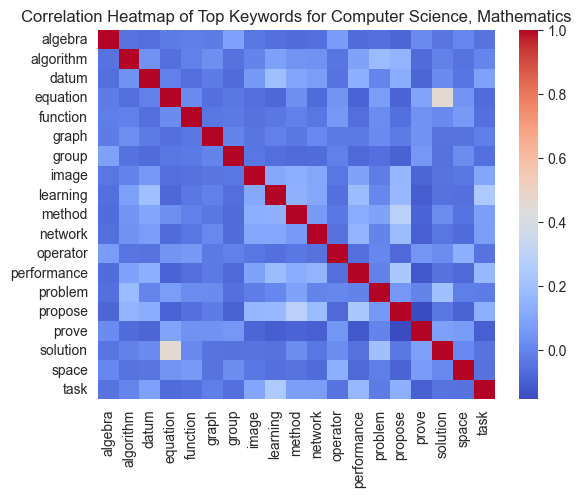

In [ ]:
# Correlation heatmap for comp. sci. and math top keywords
token_relationships_plot(tfidf, data.train.disciplines,
                         vectorizer.lemmas_,
                         ['Computer Science', 'Mathematics'],
                         kind = 'corr');
plt.savefig(image_path + 'corr_heatmap.png', dpi = 300, bbox_inches = 'tight')

The correlation heatmap above shows the relationship between the token TF-IDF vectors for the top keywords of computer science and mathematics articles. For the most part, there is very little correlation between the token vectors. There is a weak correlation between the mathematics keywords "equation" and "solution" indicating that these tokens sometimes occur together. There is also a weaker correlation between the computer science keywords "propose" and "method" and between "learning" and "task." Intuitively, it makes sense that these pairs would occur together in phrases such as: "we propose a method for..." or "a machine learning task..."

We also see that there is a very weak negative correlation between the computer science keyword "propose" and the mathematics keyword "prove." This indicates that these words do not occur together, which is what we would expect for keywords from difference disciplines.

### Collinearity

In the visualizations explored so far there has been no evidence of collinearity (i.e., correlation coefficients greater than 0.7). In addition, tokens occuring in over half of the texts have been excluded at the vectorization stage. While this does not entirely preclude the possibility of collinearity, taken together with the fact that computing the correlation coefficients for the $163,168\times 20,000$ TF-IDF matrix would be computationally expensive, tuning the vectorization hyperparameters or dimension reduction with singular value decomposition are probably more feasible approaches than attempting to detect and remove collinear TF-IDF features.  

## Exploratory Clustering

T-distributed stochastic neighbor embedding (t-SNE, van der Maaten & Hinton, 2008) is a commonly applied technique for visualizing clusters in high-dimension data while maintaining the relationships between data points.

Iterations run: 499
Kullback-Leibler divergence: 1.996


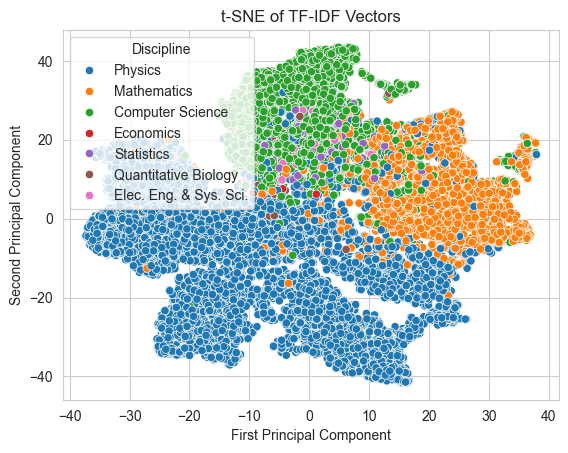

In [ ]:
def tsne_plot(X: csr_matrix, labels: pd.Series,
              perplexity: int = 50,
              svd_components: int = 8) -> plt.Axes:
    '''
    Visualize random subset of data with t-SNE
    '''
    # Downsample to speed computation
    idxs = sample_indices(X.shape[0], 0.1)

    # Reduce dimensionality to speed computation
    X_reduced = TruncatedSVD(n_components = svd_components,
                             random_state = 31
                             ).fit_transform(X[idxs,:])

    tsne = TSNE(n_components = 2, perplexity = perplexity,
                max_iter = 500, init = 'random', random_state = 31)
    X_tsne = tsne.fit_transform(X_reduced)
    print(f'Iterations run: {tsne.n_iter_}')
    print(f'Kullback-Leibler divergence: {tsne.kl_divergence_:.3f}')

    categories = labels[idxs]
    ax = sns.scatterplot(x = X_tsne[:,0], y = X_tsne[:,1],
                         hue = categories.rename('Discipline'))
    ax.set(title = 't-SNE of TF-IDF Vectors',
           xlabel = 'First Principal Component',
           ylabel = 'Second Principal Component')

    return ax

tsne_plot(tfidf, data.train.discipline);
plt.savefig(image_path + 'tsne.png', dpi = 300, bbox_inches = 'tight')

In the t-SNE plot of a random subset of the training data above, most of the physics, mathematics, and computer science texts are separated into three main clusters with some overlap. Notably, these are the three largest classes in the data set. The majority class, physics, which had only negative or no correlation with the other classes, appears to be relatively pure. In contrast, the computer science cluster appears to contain almost all of the electrical engineering and statistics texts, classes with which it was positively correlated.

## EDA Summary

The exploratory data analysis revealed a number of challenges for working with this data set. There are eight classes and 130 sub-classes, and the texts can have more than one class and sub-class label (i.e., multilabel targets). In addition, the data is not evenly distributed among these classes. There are also a large number of training samples and features. Furthermore, some of the abstracts are so undescriptive that only the title offers any clue as to which classes it might belong.

Because unsupervised learning algorithms do not use labels, it will be necessary to compare the score of every possible class permutation to determine the best class encoding in order to evaluate the models on the validation and test data (i.e., semisupervised learning). If the 130 subfield tags were used as the target, this would require $130!\approx6.5\times10^{219}$ iterations of $163,168\times130$ score calculations each time a model is fit. This is obviously impractical. Therefore, I will use the seven main disciplines as the target labels (i.e., $7!=5,040$ permutations for each model).

As discussed above, it is unrealistic to expect a balanced representation of fields for any general sample of academic articles. Therefore, the effectiveness of the models in handling imbalanced data will be part of the test of their performance. To prevent training models which ignore minority classes, the macro-average of the harmonic mean of precision and recall (i.e., macro-average F1 score) will be used for training and testing. The F1 score is considered more robust than accuracy on imbalanced data. The macro-average F1 score will be used because it gives equal weight to each class and, as a result, penalizes models that neglect minority class labels.

Finally, because the application of unsupervised learning algorithms for multilabel-multioutput classification is a largely unsettled area of active research beyond the scope of this project and only a fraction of the data is multilabel (~10%), I will limit model evaluation to semi-supervised single-label multiclass classification of the main discipline.

In [ ]:
# Delete unneeded objects to free memory
del vectorizer, tfidf
c = gc.collect()

# Models

In this section, I train the **multiple models** on the training data subset and perform **grid-search hyperparameter tuning** using the **validation** subset with F1 scores to manage class **imbalance.** As previously explained, the unsupervised learning models to be compared are latent semantic analysis (LSA), non-negative matrix factorization (NMF), and latent Dirichlet allocation (LDA). These will be compared with a class prior model which always predicts the majority class, as well as a supervised learning random forest model.

## Hyperparameter Tuning

Grid-search hyperparameter tuning for each model is performed by fitting the model to the training data and then evaluating performance measured by the macro-average F1 score on the validation data set. As previously explained, the data has already been split using stratified sampling into training, validation, and test sets in an 80:10:10 ratio.

In [ ]:
class GridSearch:
    '''
    Grid search validation for vectorizer paired with estimator
    '''
    def __init__(self, param_grid: dict,
                 vectorizer = Vectorizer(),
                 estimator = DummyClassifier(),
                 refit = True, verbose = True):
        self.param_grid = param_grid
        self.vectorizer = vectorizer
        self.estimator = estimator
        self.refit = refit
        self.verbose = verbose

    def fit(self, lemmas: namedtuple, data: namedtuple):
        results = {'f1_test_score': [],
                   'accuracy_test_score': [],
                   'rank_test_score': [],
                   'fit_score': [],
                   'fit_time': [],
                   'score_time': [],
                   'params': []}

        for params in iter(self.param_grid):
            # Fit and transform training data
            results['params'].append(params)
            vectorizer = clone(self.vectorizer)
            vectorizer.set_params(**params)
            tfidf_train = vectorizer.fit_transform(lemmas.train)
            clf = clone(self.estimator)
            start = time.perf_counter()
            clf.fit(tfidf_train, data.train.discipline)
            stop = time.perf_counter()
            results['fit_time'].append(stop - start)
            results['fit_score'].append(clf.fit_score_)

            # Transform and score validation data
            tfidf_validation = vectorizer.transform(lemmas.validation)
            start = time.perf_counter()
            f1_score = clf.score(tfidf_validation,
                                 data.validation.discipline,
                                 metric = 'f1_macro')
            stop = time.perf_counter()
            acc_score = clf.score(tfidf_validation,
                                  data.validation.discipline,
                                  metric = 'accuracy')
            results['score_time'].append(stop - start)
            results['f1_test_score'].append(f1_score)
            results['accuracy_test_score'].append(acc_score)

        results['rank_test_score'] = np.flip(np.argsort(results['f1_test_score'])
                                                   ).argsort() + 1

        best_idx = np.argmin(results['rank_test_score'])
        self.best_params_ = results['params'][best_idx]
        self.best_score_ = results['f1_test_score'][best_idx]
        self.accuracy_score_ = results['accuracy_test_score'][best_idx]
        self.fit_score_ = results['fit_score'][best_idx]
        self.predict_time_ = results['score_time'][best_idx]
        self.fit_time_ = results['fit_time'][best_idx]
        self.results_ = results

        if self.verbose:
            print(f'Best parameters: {self.best_params_}')
            print(f'Best validation F1 score: {self.best_score_:.2%}')
            print(f'Accuracy score (best_parameters): {self.accuracy_score_:.2%}')
            print(f'Fit score (best parameters): {self.fit_score_:.2%}')
            print(f'Predict time (best parameters): {self.predict_time_:.5f} s')
            print(f'Fit time (best parameters): {self.fit_time_:.2f} s')

        if self.refit:
            # Refit training set with best parameters
            self.best_vectorizer_ = clone(self.vectorizer)
            self.best_vectorizer_.set_params(**self.best_params_)
            tfidf_train = self.best_vectorizer_.fit_transform(lemmas.train)
            self.best_estimator_ = clone(self.estimator)
            start = time.perf_counter()
            self.best_estimator_.fit(tfidf_train, data.train.discipline)
            stop = time.perf_counter()
            self.refit_time_ = stop - start

        self._is_fitted = True

        return self

    def gridsearch_plot(self, model_name: str = '') -> plt.Axes:
        '''
        Plot grid-search scores
        '''
        if hasattr(self, '_is_fitted') and self._is_fitted:
            params = pd.DataFrame(self.results_['params'])
            scores = pd.DataFrame({'F1 Score': self.results_['f1_test_score']})
            df = pd.concat([params, scores], axis = 1)
            x_axis_label = params.columns[1]
            hue_label = params.columns[0]
            title = f'{model_name} Model TF-IDF Vectorizer Grid Search Scores'
            sns.set_style('whitegrid')
            palette = sns.color_palette(n_colors = params.iloc[:, 0].unique().size)
            ax = sns.lineplot(df, x = x_axis_label, y = 'F1 Score',
                            hue = hue_label, palette = palette)
            ax.set_xticks(df[x_axis_label])
            ax.set(title = title)
            return ax
        else: return None

# Dict and keys to store models
models = {}
cp_key = 'Class Prior'
lsa_key = 'LSA'
nmf_fr_key = 'NMF-Fr'
nmf_kl_key = 'NMF-KL'
lda_key = 'LDA'

### Class Prior Baseline Model

A model which always predicts the majority class label is used as a baseline for comparison. Because it makes the same prediction regardless of the input features, hyperparameter tuning has no effect.

In [ ]:
class ClassPriorModel(ClassifierMixin, BaseEstimator):
    '''
    Class prior model: Always predicts majority class label
    '''
    def __init__(self, estimator = DummyClassifier(strategy = 'prior')):
        self.estimator = estimator

    def fit(self, X: csr_matrix, y: pd.Series):
        '''
        Obtain class priors from y
        X is ignored
        '''
        self._check_n_observations(X, y)
        self._estimator = clone(self.estimator)
        self._estimator.fit(X, y)
        self.classes_ = self._estimator.classes_
        self.n_classes_ = self._estimator.n_classes_
        self.class_prior_ = self._estimator.class_prior_ if hasattr(self._estimator, 'class_prior_') else None
        self.n_features_in_ = X.shape[1]
        self._is_fitted = True
        self.fit_score_ = self.score(X, y, 'f1_macro')
        return self

    def predict(self, X: csr_matrix) -> np.ndarray:
        '''
        Return majority class label for all observations in X
        regardless of features
        '''
        self._check_is_fitted()
        self._check_n_features(X)
        return self._estimator.predict(X)

    def score(self, X: csr_matrix, y: pd.Series,
              metric: str = 'f1_macro') -> np.float64:
        '''
        Subset accuracy score on document-term matrix X and labels y
        '''
        self._check_is_fitted()
        self._check_n_features(X)
        self._check_n_observations(X, y)
        if metric == 'accuracy':
            return self._estimator.score(X, y)
        else:
            y_predicted = self.predict(X)
            match metric:
                case 'balanced_accuracy':
                    return balanced_accuracy_score(y, y_predicted)
                case 'f1_micro':
                    return f1_score(y, y_predicted, average = 'micro')
                case 'f1_macro':
                    return f1_score(y, y_predicted, average = 'macro')
                case 'f1_weighted':
                    return f1_score(y, y_predicted, average = 'weighted')
                case _:
                    raise ValueError(f'{metric} is not an option')

    def _check_is_fitted(self):
        if not hasattr(self, '_is_fitted') or not self._is_fitted:
            raise RuntimeError('Instance is not yet fitted.')

    def _check_n_features(self, X: csr_matrix):
        observed = X.shape[1]
        if observed != self.n_features_in_:
            raise ValueError(f'{observed} features, but expecting {self.n_features_in_}')

    def _check_n_observations(self, X: csr_matrix, y: pd.Series):
        if X.shape[0] != y.shape[0]:
            raise ValueError('Number of labels must match number of observations')


Best parameters: {'max_df': 1.0, 'max_features': 5000}
Best validation F1 score: 10.43%
Accuracy score (best_parameters): 57.53%
Fit score (best parameters): 10.44%
Predict time (best parameters): 0.08427 s
Fit time (best parameters): 0.97 s


,Class Prior
Computer Science,0.202
Economics,0.002
Elec. Eng. & Sys. Sci.,0.005
Mathematics,0.197
Physics,0.576
Quantitative Biology,0.004
Statistics,0.013


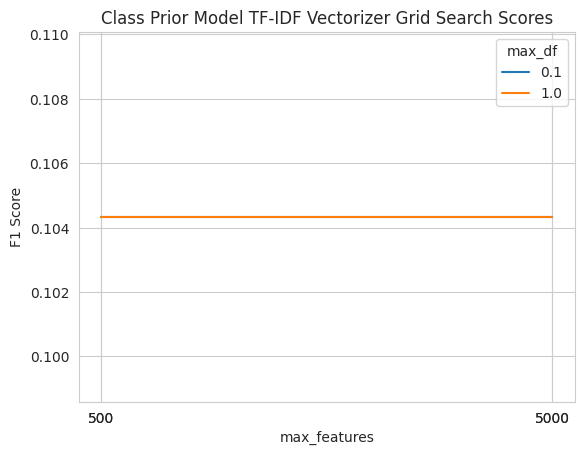

In [ ]:
# Demonstrate futility of feature engineering on class prior model

param_grid = ParameterGrid({'max_df': [0.1, 1.0],
                            'max_features': [500, 5000]})

models[cp_key] = GridSearch(param_grid = param_grid,
                            vectorizer = Vectorizer(),
                            estimator = ClassPriorModel()
                            ).fit(lemmas, data)

models[cp_key].gridsearch_plot(cp_key);
plt.savefig(image_path + 'cp_gridsearch.png', dpi = 300, bbox_inches = 'tight')

pd.DataFrame(models[cp_key].best_estimator_.class_prior_,
             columns = [cp_key],
             index = models[cp_key].best_estimator_.classes_).round(3)

The grid search plot for the class-prior model above demonstrates that feature engineering has no effect on the model's score. This is because it will always predict the training set majority class label ("physics") for any unseen data regardless of the features. This strategy results in an accuracy score of 58% on the validation data, but a macro-average F1 score of only 10%. This demonstrates how the accuracy metric rewards models which favor the majority class in imbalanced data, while the macro-average F1 score penalizes such models.

### Latent Semantic Analysis Model

The latent semantic analysis (LSA) model requires sublinear term-frequency ($tf$) vectors (Amor et al., n.d.):
$$tf_{sublinear} = 1 + \log(tf)$$
The optimal TF-IDF hyperparameters for the model are determined using grid search.

In [ ]:
class LSA(ClassPriorModel):
    '''
    Latent semantic analysis model
    '''
    def __init__(self, estimator = TruncatedSVD(), random_state = 31):
        super().__init__(estimator)
        self.random_state = random_state

    def fit(self, X: csr_matrix, y: pd.Series):
        '''
        Train model by decomposing document-term matrix X
        and obtain encoding that maximizes balanced accuracy
        against labels y
        '''
        self._check_n_observations(X, y)
        self.classes_ = y.unique()
        self.n_classes_ = self.classes_.size
        self.n_features_in_ = X.shape[1]
        self._estimator = self._set_parameters(self.estimator)
        doc_topic = self._estimator.fit_transform(X)
        self.encoding_ = self._best_encoding(doc_topic, y)
        self.topic_term_ = self._estimator.components_
        self._is_fitted = True
        return self

    def predict(self, X: csr_matrix) -> np.ndarray:
        '''
        Return predicted labels for document-term matrix X
        '''
        self._check_is_fitted()
        self._check_n_features(X)
        doc_topic = self._estimator.transform(X)
        predictions = pd.Series(np.argmax(doc_topic, axis = 1))
        return predictions.map(self.encoding_).to_numpy()

    def score(self, X: csr_matrix, y: pd.Series,
              metric: str = 'f1_macro') -> np.float64:
        '''
        Subset accuracy score on document-term matrix X and labels y
        '''
        self._check_is_fitted()
        self._check_n_features(X)
        self._check_n_observations(X, y)
        y_predicted = self.predict(X)
        match metric:
            case 'accuracy':
                return accuracy_score(y, y_predicted)
            case 'balanced_accuracy':
                return balanced_accuracy_score(y, y_predicted)
            case 'f1_micro':
                return f1_score(y, y_predicted, average = 'micro')
            case 'f1_macro':
                return f1_score(y, y_predicted, average = 'macro')
            case 'f1_weighted':
                return f1_score(y, y_predicted, average = 'weighted')
            case _:
                raise ValueError(f'{metric} is not an option')

    def transform(self, X: csr_matrix) -> np.ndarray:
        '''
        Decompose document-term matrix X
        using fitted instance
        '''
        self._check_is_fitted()
        self._check_n_features(X)
        return self._estimator.transform(X)

    def _best_encoding(self, doc_topic: np.ndarray, y: pd.Series) -> np.ndarray:
        '''
        Return encoding that maximizes macro-average F1 score
        '''
        y_predicted = np.argmax(doc_topic, axis = 1)
        permutations = itertools.permutations(range(self.n_classes_))
        max_score = 0
        best_permutation = None
        for permutation in permutations:
            encoding = dict(zip(self.classes_, permutation))
            y_encoded = y.map(encoding)
            score = f1_score(y_encoded, y_predicted, average = 'macro')
            if score > max_score:
                max_score = score
                best_permutation = permutation
        best_encoding = dict(zip(best_permutation, self.classes_))
        self.fit_score_ = max_score
        return best_encoding

    def _set_parameters(self, estimator: BaseEstimator) -> BaseEstimator:
        '''
        Clone estimator and set parameters
        '''
        _estimator = clone(estimator)
        _estimator.set_params(n_components = self.n_classes_,
                              random_state = self.random_state)
        return _estimator


Best parameters: {'max_df': 0.1, 'max_features': 700}
Best validation F1 score: 25.76%
Accuracy score (best_parameters): 63.50%
Fit score (best parameters): 25.64%
Predict time (best parameters): 0.10577 s
Fit time (best parameters): 133.38 s


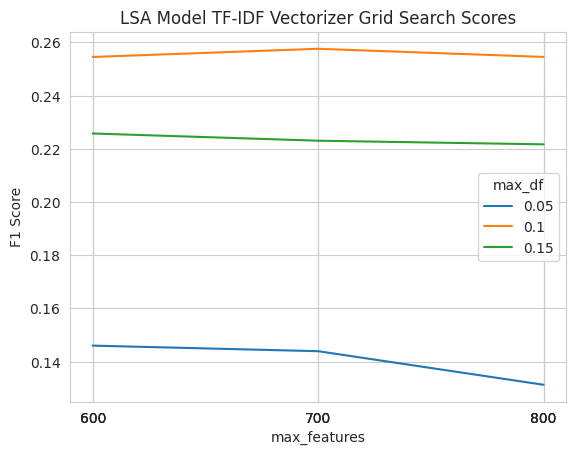

In [ ]:
param_grid = ParameterGrid({'max_df': [0.05, 0.1, 0.15],
                            'max_features': [600, 700, 800]})

models[lsa_key] = GridSearch(param_grid = param_grid,
                             vectorizer = Vectorizer(sublinear_tf = True),
                             estimator = LSA()
                             ).fit(lemmas, data)

models[lsa_key].gridsearch_plot(lsa_key);
plt.savefig(image_path + 'lsa_gridsearch.png', dpi = 300, bbox_inches = 'tight')

The grid-search plot above shows that the LSA model achieves the best validation F1 score (26%) when trained on the TD-IDF vectors of the 700 most frequent tokens which only occur in 10% or fewer of the corpus of training texts.

### Non-Negative Matrix Factorization Model

As the name suggests non-negative matrix factorization (NMF) requires non-negative matrices, so the standard TF-IDF vectors (not sublinear) must be used. A number of loss functions can be used when training the non-negative matrix factorization (NMF) model. First, I train a model using the faster Frobenius norm loss function.

In [ ]:
class NMFTopicModel(LSA):
    '''
    Non-negative matrix factorization
    '''
    def __init__(self, estimator=NMF(),
                 beta_loss = 'frobenius',
                 random_state = 31):
        super().__init__(estimator)
        self.solver = 'cd' if beta_loss == 'frobenius' else 'mu'
        self.beta_loss = beta_loss
        self.random_state = random_state

    def _set_parameters(self, estimator: BaseEstimator) -> BaseEstimator:
        '''
        Clone estimator and set parameters
        '''
        _estimator = clone(estimator)
        _estimator.set_params(n_components = self.n_classes_,
                              solver = self.solver,
                              beta_loss = self.beta_loss,
                              random_state = self.random_state)
        return _estimator

Best parameters: {'max_df': 0.05, 'max_features': 2500}
Best validation F1 score: 30.33%
Accuracy score (best_parameters): 55.76%
Fit score (best parameters): 30.40%
Predict time (best parameters): 0.13932 s
Fit time (best parameters): 149.42 s


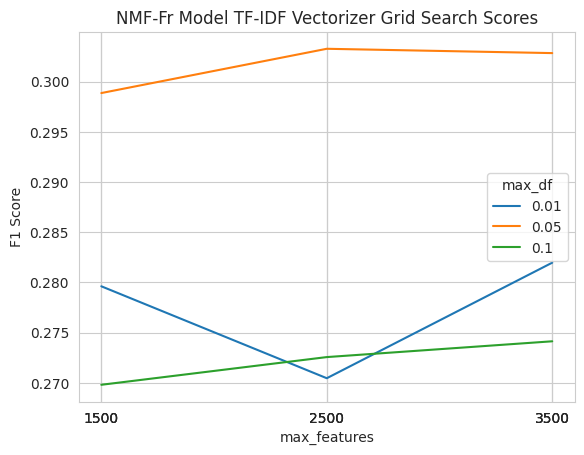

In [ ]:
# Frobenius loss function NMF grid search

param_grid = ParameterGrid({'max_df': [0.01, 0.05, 0.1],
                            'max_features': [1500, 2500, 3500]})

models[nmf_fr_key] = GridSearch(param_grid = param_grid,
                                 vectorizer = Vectorizer(),
                                 estimator = NMFTopicModel()
                                 ).fit(lemmas, data)

models[nmf_fr_key].gridsearch_plot(nmf_fr_key);
plt.savefig(image_path + 'nmf_frb_gridsearch.png', dpi = 300, bbox_inches = 'tight')

The above plot shows that the NMF-Frobenius (NMF-Fr) model achieves the best validation F1 score (30%) when trained on the 2,500 most frequent TF-IDF features which occur in 5% or fewer of the training texts. However, the Frobenius loss function is known to perform poorly on sparse matrices (such as TF-IDF matrices), so next, I train the model using the Kullback-Leibler (KL) loss function, which is robust to sparse input.

Best parameters: {'max_df': 0.05, 'max_features': 3000}
Best validation F1 score: 31.41%
Accuracy score (best_parameters): 48.28%
Fit score (best parameters): 31.48%
Predict time (best parameters): 3.52380 s
Fit time (best parameters): 267.65 s


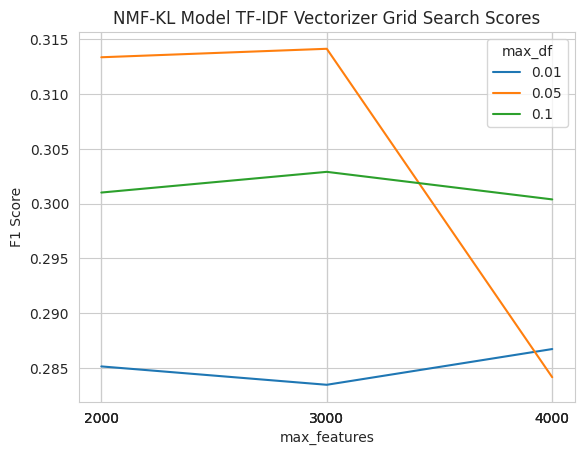

In [ ]:
# Kullback-Leibler loss function NMF grid search

param_grid = ParameterGrid({'max_df': [0.01, 0.05, 0.1],
                            'max_features': [2000, 3000, 4000]})

models[nmf_kl_key] = GridSearch(param_grid = param_grid,
                                 vectorizer = Vectorizer(),
                                 estimator = NMFTopicModel(beta_loss = 'kullback-leibler')
                                 ).fit(lemmas, data)

models[nmf_kl_key].gridsearch_plot(nmf_kl_key);
plt.savefig(image_path + 'nmf_kl_gridsearch.png', dpi = 300, bbox_inches = 'tight')

The chart above indicates that the NMF-KL model achieves the highest validation F1 score (31%) when trained on the 3,000 most frequent tokens which only occur in 5% or fewer of the training corpus. This is a slight improvement over the NMF-Fr model, but it requires more data and is slower to train.

### Latent Dirichlet Allocation Model

In [ ]:
class LDA(LSA):
    '''
    Latent Dirichlet allocation model
    '''
    def __init__(self,
                 estimator = LatentDirichletAllocation(),
                 learning_method = 'online',
                 random_state = 31):
        super().__init__(estimator)
        self.learning_method = learning_method
        self.random_state = random_state

    def _set_parameters(self, estimator: BaseEstimator) -> BaseEstimator:
        '''
        Clone estimator and set parameters
        '''
        _estimator = clone(estimator)
        _estimator.set_params(n_components = self.n_classes_,
                              learning_method = self.learning_method,
                              random_state = self.random_state)
        return _estimator

Best parameters: {'max_df': 0.1, 'max_features': 5000}
Best validation F1 score: 35.32%
Accuracy score (best_parameters): 61.10%
Fit score (best parameters): 34.15%
Predict time (best parameters): 3.58236 s
Fit time (best parameters): 472.82 s


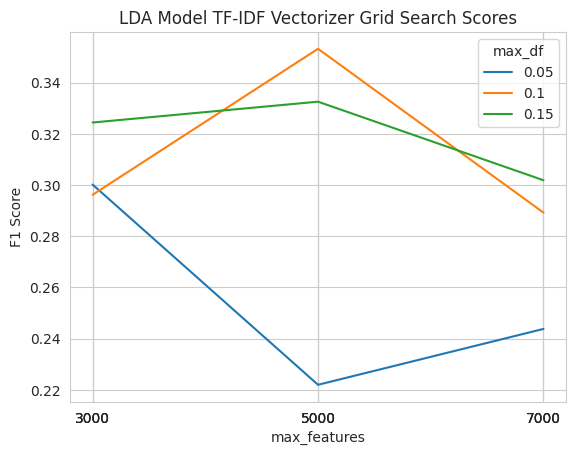

In [ ]:
# LDA grid search

param_grid = ParameterGrid({'max_df': [0.05, 0.1, 0.15],
                            'max_features': [3000, 5000, 7000]})

models[lda_key] = GridSearch(param_grid = param_grid,
                             vectorizer = Vectorizer(),
                             estimator = LDA()
                             ).fit(lemmas, data)

models[lda_key].gridsearch_plot(lda_key);
plt.savefig(image_path + 'lda_gridsearch.png', dpi = 300, bbox_inches = 'tight')

In the above chart, the LDA model performs best (35%) when trained on the 5,000 most frequent tokens which occur in only 10% or fewer of the corpus.

### Random Forest

A supervised learning random forest model is included for comparison. The same vectorization hyperparameters from the highest performing unsupervised LDA model are used.

In [ ]:
class RandomForest(ClassPriorModel):
    '''
    Random forest model
    '''
    def __init__(self, estimator = RandomForestClassifier(n_estimators = 100,
                                                          max_depth = 50,
                                                          random_state = 31,
                                                          class_weight = 'balanced')):
        super().__init__(estimator)

In [ ]:
# Fit random forest model with optimized LDA vectorizer parameters
rf_key = 'Random Forest'

param_grid = ParameterGrid({'max_df': [0.1],
                            'max_features': [5000]})

models[rf_key] = GridSearch(param_grid = param_grid,
                             vectorizer = Vectorizer(),
                             estimator = RandomForest()
                             ).fit(lemmas, data)

Best parameters: {'max_df': 0.1, 'max_features': 5000}
Best validation F1 score: 52.63%
Accuracy score (best_parameters): 87.34%
Fit score (best parameters): 95.87%
Predict time (best parameters): 0.84249 s
Fit time (best parameters): 309.37 s


Even without hyperparameter tuning, the random forest model achieves a much higher validation F1 score (52%) than the LDA model (35%).

In [ ]:
# Save as pickle object
with open(pickle_path + 'models.pickle', 'wb') as f:
	pickle.dump(models, f, pickle.HIGHEST_PROTOCOL)

## Models Summary

**Multiple unsupervised learning models** and two comparison models were trained using a training data subset. A **validation** subset was used to tune the text vectorization **hyperparameters** as well as the NMF model loss function **hyperparameter**.
Macro-average F1 score was used to **manage data imbalance**.

# Results and Analysis

In this section, several **visualizations** and statistical tests are used to compare the **performances of multiple models** using **multiple metrics**.

In [ ]:
class ModelMetrics:
    '''
    Measure models' performance using bootstrapped test data
    '''
    def fit(self, models: dict, lemmas: Lemmas, data: Data,
            repetitions = 5, verbose = False):
        '''
        Perform bootstrap measurements
        '''

        self.models_ = models
        self.predictions_ = {}
        self.test_labels_ = data.test.discipline

        # Initialize model lists for each metric
        self.f1_key_ = 'Macro F1'
        self.acc_key_ = 'Accuracy'
        self.fit_time_key_ = 'Fit Time'
        self.predict_time_key_ = 'Prediction Time'
        self.model_key_ = 'Model'
        self.metric_key_ = 'Metric'
        self.measurement_key_ = 'Measurement'
        self.results_dict_ = {self.f1_key_: {},
                              self.acc_key_: {},
                              self.fit_time_key_: {},
                              self.predict_time_key_: {}}

        for model_key, model in models.items():
            if not model.refit:
                raise ValueError('Models must be refit with best vectorizer and estimator')
            for metric in self.results_dict_.values():
                metric[model_key] = []

        for i in range(repetitions):
            if verbose:
                print(f'Prediction iteration: {i + 1}')

            # Bootstrap sample
            lemmas_sample, labels_sample = resample(lemmas.test,
                                                    data.test.discipline,
                                                    random_state = i)

            for model_key, model in models.items():
                if verbose:
                    print(f'  Measuring {model_key}')

                # Predict, score, and time
                tfidf = model.best_vectorizer_.transform(lemmas_sample)
                start = time.perf_counter()
                labels_pred = model.best_estimator_.predict(tfidf)
                stop = time.perf_counter()
                self.results_dict_[self.predict_time_key_][model_key].append(stop - start)
                self.results_dict_[self.f1_key_][model_key].append(f1_score(labels_sample, labels_pred, average = 'macro'))
                self.results_dict_[self.acc_key_][model_key].append(accuracy_score(labels_sample, labels_pred))

                # Get non-bootstrapped predictions for confusion matrices
                tfidf = model.best_vectorizer_.transform(lemmas.test)
                self.predictions_[model_key] = model.best_estimator_.predict(tfidf)

        # Get 5 fit times (due to runtime constraints)
        for model_key, model in models.items():
            if verbose:
                print(f'Recording fit times for {model_key}')

            # Get 2 fit times already recorded during gridsearch
            self.results_dict_[self.fit_time_key_][model_key].append(model.fit_time_)
            self.results_dict_[self.fit_time_key_][model_key].append(model.refit_time_)

            # Get 3 more fit times
            tfidf = model.best_vectorizer_.transform(lemmas.train)
            clf = clone(model.best_estimator_)
            for i in range(3):
                if verbose:
                    print(f'  Iteration {i + 1}')
                start = time.perf_counter()
                clf.fit(tfidf, data.train.discipline)
                stop = time.perf_counter()
                self.results_dict_[self.fit_time_key_][model_key].append(stop - start)

        self._is_fitted = True
        self.results_df_ = self._long_format_df(self.results_dict_)
        return self

    def _check_is_fitted(self):
        if not hasattr(self, '_is_fitted') or not self._is_fitted:
            raise RuntimeError('Instance is not yet fitted.')

    def _long_format_df(self, results: dict) -> pd.DataFrame:
        '''
        Make long-format dataframe
        '''
        self._check_is_fitted()
        metric_df_dict = {}
        for metric, models in results.items():
            model_df_dict = {}
            for model_key, measurements in models.items():
                model_df_dict[model_key] = pd.DataFrame(measurements)
            metric_df_dict[metric] = pd.concat(model_df_dict, axis = 0)
        results_df = pd.concat(metric_df_dict, axis = 0
                               ).stack().to_frame(self.measurement_key_)
        results_df.index.set_names([self.metric_key_,
                                    self.model_key_,
                                    'Iteration',
                                    'extra'],
                                    inplace = True)
        results_df.reset_index(inplace = True)
        results_df.drop(columns = 'extra', inplace = True)
        return results_df


In [ ]:
# Load pickle object
# with open(pickle_path + 'models.pickle', 'rb') as f:
#     models = pickle.load(f)

In [ ]:
# Compute evaluation metrics for models
model_metrics = ModelMetrics().fit(models, lemmas, data, repetitions = 10, verbose = False)

In [ ]:
# Save as pickle object
with open(pickle_path + 'model_metrics.pickle', 'wb') as f:
	pickle.dump(model_metrics, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
class ModelEvaluation:
    '''
    Analyze and visualize model metrics
    '''
    def fit(self, model_metrics: ModelMetrics):
        '''
        Extract metrics and metadata for analysis
        '''
        self.models_ = model_metrics.models_
        self.predictions_ = model_metrics.predictions_
        self.test_labels_ = model_metrics.test_labels_
        self.results_df_ = model_metrics.results_df_
        self.results_dict_ = model_metrics.results_dict_
        self.f1_key_ = model_metrics.f1_key_
        self.acc_key_ = model_metrics.acc_key_
        self.fit_time_key_ = model_metrics.fit_time_key_
        self.predict_time_key_ = model_metrics.predict_time_key_
        self.model_key_ = model_metrics.model_key_
        self.metric_key_ = model_metrics.metric_key_
        self.measurement_key_ = model_metrics.measurement_key_
        self._is_fitted = True
        return self

    def box_plots(self, metrics = ['Macro F1', 'Accuracy'],
                  metric_type = 'Score') -> sns.FacetGrid:
        '''
        Box plots of models' bootstrapped test results
        for one or two metrics
        '''
        self._check_is_fitted()
        filtered_df = self.results_df_[self.results_df_[self.metric_key_].isin(metrics)]
        title = f'{metrics[0]}'
        xlabel = f'{metrics[0]}'
        hue = None
        if len(metrics) == 2:
            hue = self.metric_key_
            title = f'{metric_type} Metric Comparison'
            xlabel = f'{metric_type}'

        sns.set_style('whitegrid')
        ax = sns.catplot(data = filtered_df,
                         x = self.measurement_key_,
                         y = self.model_key_,
                         hue = hue, kind = 'box', aspect = 1.5)
        ax.set(title = title, xlabel = xlabel)
        return ax

    def confidence_interval_df(self, metric = 'Macro F1',
                               alpha = 0.05,
                               ascending = False) -> pd.DataFrame:
        '''
        Estimate (1 - alpha)% confidence intervals for metric mean
        for each models, sorted by lower bound
        '''
        self._check_is_fitted()
        conf_ints = {}
        lower_ci_key = 'Lower'
        upper_ci_key = 'Upper'
        for model_key, measurements in self.results_dict_[metric].items():
            conf_ints[model_key] = {}
            lower, upper = sms.DescrStatsW(measurements).tconfint_mean(alpha = alpha)
            conf_ints[model_key][lower_ci_key] = lower
            conf_ints[model_key][upper_ci_key] = upper

        conf_int_df = pd.DataFrame(conf_ints).T
        conf_int_df = conf_int_df.sort_values(lower_ci_key, ascending = ascending)
        conf_int_df.index.set_names([self.model_key_], inplace = True)
        return conf_int_df

    def confidence_intervals_plot(self, metric = 'Macro F1',
                                  alpha = 0.05) -> plt.Axes:
        '''
        Plot (1 - alpha)% confidence intervals for metric mean
        for each model
        '''
        self._check_is_fitted()
        filtered_df = self.results_df_[self.results_df_[self.metric_key_] == metric]
        conf_int_df = self.confidence_interval_df(metric, alpha)
        order = conf_int_df.index.values.tolist()
        conf_level = (1 - alpha)

        sns.set_style('whitegrid')
        ax = sns.pointplot(data = filtered_df,
                           x = self.measurement_key_,
                           y = self.model_key_,
                           order = order,
                           errorbar = ('ci', conf_level * 100),
                           capsize = 0.3, linestyle = 'none',
                           linewidth = 2)
        ax.set(title = f'{conf_level:.0%} Confidence Intervals for {metric} Mean')
        return ax

    def confusion_matrix_plot(self, model_key: str) -> ConfusionMatrixDisplay:
        self._check_is_fitted()
        labels = np.sort(self.test_labels_.unique())
        sns.set_style('white')
        cm = confusion_matrix(self.test_labels_, self.predictions_[model_key])
        cmd = ConfusionMatrixDisplay(cm, display_labels = labels)
        cmd.plot()
        cmd.ax_.set_title(f'{model_key} Model Confusion Matrix')
        plt.xticks(rotation = 45, ha = 'right')
        return cmd

    def keywords_plot(self, model_key: str,
                      topic_type: str = 'Discipline',
                      n_keywords = 10) -> plt.Figure:
        '''
        Plot top keywords for model using
        ranked embeddings of topic-term matrix
        '''
        self._check_is_fitted()
        model = self.models_[model_key]

        if not hasattr(model.best_estimator_, 'topic_term_'):
            return None

        topic_term = model.best_estimator_.topic_term_
        encoding = model.best_estimator_.encoding_
        sorted_encoding = {idx: topic for idx, topic in sorted(encoding.items(), key = lambda item: item[1])}
        tokens = model.best_vectorizer_.lemmas_
        n_topics = len(encoding)

        sns.set_style('whitegrid')
        fig, axs = plt.subplots(ncols = math.ceil(n_topics / 2),
                                nrows = 2,
                                figsize = (n_topics,
                                           math.ceil(n_keywords / 2)))
        axs = axs.ravel()

        # Trim extra axes
        for ax in axs[n_topics:]:
            ax.remove()

        title = f'{model_key} Model: {n_keywords} Most Salient Keywords by {topic_type}'
        fig.suptitle(title)
        fig.supxlabel('Salience (topic-term embedding)')
        fig.supylabel('Keyword')
        for axs_idx, (topic_idx, topic) in enumerate(sorted_encoding.items()):
            term_embeddings = topic_term[topic_idx]
            keyword_idxs = term_embeddings.argsort()[-n_keywords:]
            keywords = tokens[keyword_idxs]
            salience = term_embeddings[keyword_idxs]
            axs[axs_idx].barh(y = keywords, width = salience, alpha = 0.8)
            axs[axs_idx].set_title(topic)
        fig.tight_layout()
        return fig

    def welch_anova(self, metric = 'Macro F1', alpha = 0.05) -> tuple:
        '''
        Perform Welch's ANOVA test on metric,
        and if significant (p < alpha),
        perform Games-Howell pairwise comparisons
        '''
        self._check_is_fitted()
        filtered_df = self.results_df_[self.results_df_[self.metric_key_] == metric]
        aov = pg.welch_anova(data = filtered_df,
                             dv = self.measurement_key_,
                             between = self.model_key_)
        gh = None
        if aov['p-unc'][0] < alpha:
            gh = pg.pairwise_gameshowell(data = filtered_df,
                                         dv = self.measurement_key_,
                                         between = self.model_key_)
        return aov, gh

    def _check_is_fitted(self):
        if not hasattr(self, '_is_fitted') or not self._is_fitted:
            raise RuntimeError('Instance is not yet fitted.')


In [ ]:
# Load pickle object
# with open(pickle_path + 'model_metrics.pickle', 'rb') as f:
#     model_metrics = pickle.load(f)

In [ ]:
# Extract model measurement for evaluation
model_evaluation = ModelEvaluation().fit(model_metrics)

In [ ]:
# Save as pickle object
with open(pickle_path + 'model_evaluation.pickle', 'wb') as f:
	pickle.dump(model_evaluation, f, pickle.HIGHEST_PROTOCOL)

## Prediction Scores

I begin by comparing the models' prediction performance using macro-average F1 scores and accuracy scores.

### Macro-Average F1 Score

In the box plots of the models' macro-average F1 scores below, we see that there is no overlap of interquartile ranges (IQR) of each model's distribution and that the variance does not appear to be equal across models. 

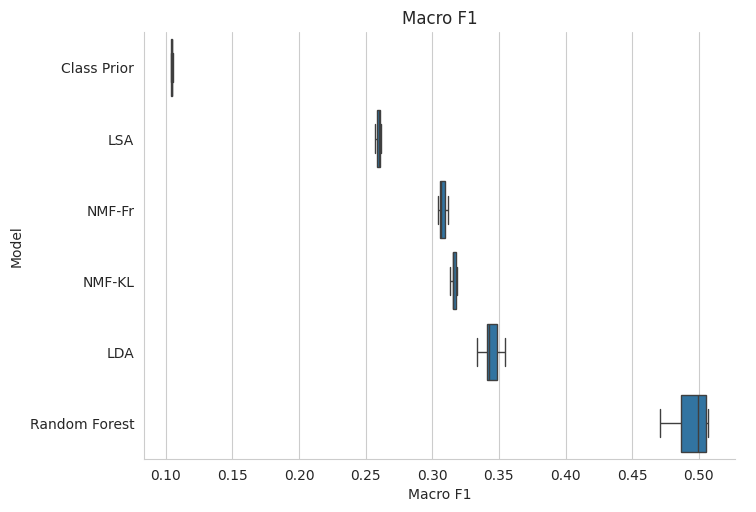

In [ ]:
# Score metric box plots
model_evaluation.box_plots(metrics = ['Macro F1']);
plt.savefig(image_path + 'score_box.png', dpi = 300, bbox_inches = 'tight')

To test whether differences exist between the mean scores of the models with data with non-homogenous variance, Welch's ANOVA can be used (Field et al., 2012). Before performing the test, the significance threshold is set at $\alpha=0.05$.

In [ ]:
# Welch's ANOVA for F1 mean
aov, gh = model_evaluation.welch_anova()
aov

,Source,ddof1,ddof2,F,p-unc,np2
0,Model,5,22.531227,50415.662668,8.131583e-45,0.997491


In the above results, the p-value far below the significance threshold indicates that there are significant differences between at least some of the models' F1 scores. To determine where those differences lie, Games-Howell post-hoc pairwise comparison controlling for familywise error and assuming non-homogenous variance are performed.

In [ ]:
# Games-Howell pairwise comparisons for F1 mean
gh.round(3)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Class Prior,LDA,0.104,0.344,-0.239,0.002,-109.369,9.097,0.0,-46.845
1,Class Prior,LSA,0.104,0.260,-0.155,0.001,-288.130,10.727,0.0,-123.411
2,Class Prior,NMF-Fr,0.104,0.308,-0.203,0.001,-276.828,9.900,0.0,-118.570
3,Class Prior,NMF-KL,0.104,0.316,-0.212,0.001,-377.630,10.588,0.0,-161.745
4,Class Prior,Random Forest,0.104,0.495,-0.390,0.004,-96.070,9.028,0.0,-41.148
5,LDA,LSA,0.344,0.260,0.084,0.002,37.395,10.000,0.0,16.017
6,LDA,NMF-Fr,0.344,0.308,0.036,0.002,15.716,10.917,0.0,6.732
7,LDA,NMF-KL,0.344,0.316,0.027,0.002,12.211,10.089,0.0,5.230
8,LDA,Random Forest,0.344,0.495,-0.151,0.005,-32.781,13.798,0.0,-14.041
9,LSA,NMF-Fr,0.260,0.308,-0.048,0.001,-54.116,16.345,0.0,-23.179


Because the p-values for each comparison are below the threshold, we reject the null hypothesis that the pairwise mean F1 scores are the same.

The confidence interval plot below visualizes these differences.

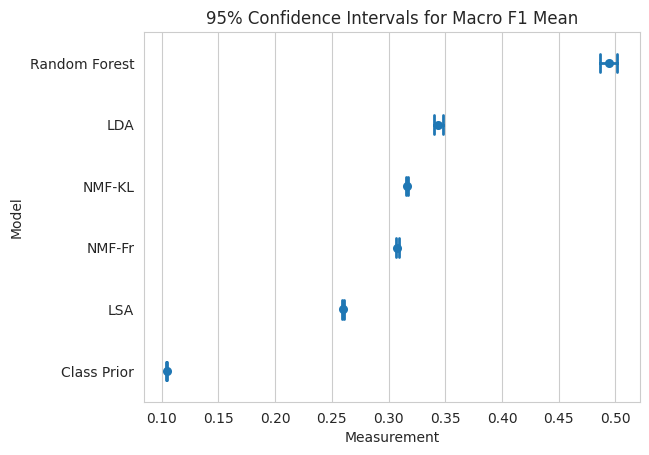

In [ ]:
# Macro F1 score confidence intervals
model_evaluation.confidence_intervals_plot();
plt.savefig(image_path + 'f1_ci.png', dpi = 300, bbox_inches = 'tight')

In the 95% confidence interval plot of Macro-average F1 means above, none of the confidence intervals overlap, as expected based on the previous statistical tests. Confidence intervals which do not overlap correspond to p-values of 0.006 or lower (Cumming & Finch, 2005), but this estimate should be adjusted for family-wise error. We can see that the supervised learning random forest model outperforms the unsupervised learning models (i.e., LDA, NMF, and LSA). The class prior model performs the worst. Of the unsupervised learning algorithms, LDA performs the best followed by the NMF-KL, NMF-Fr, and LSA models in descending order.

### Accuracy

For comparison, accuracy scores are visualized below.

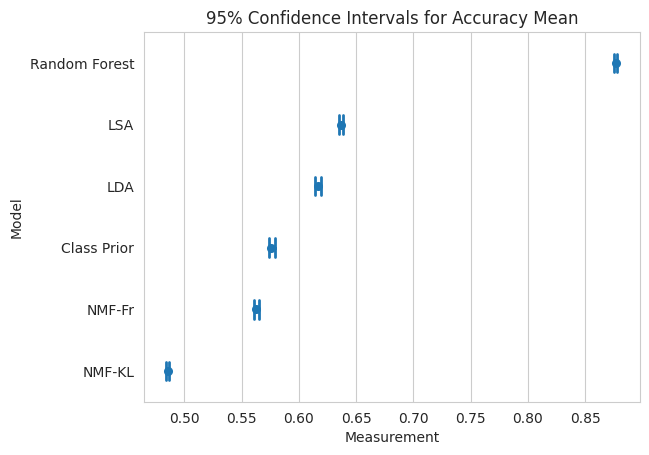

In [ ]:
# Accuracy score confidence intervals
model_evaluation.confidence_intervals_plot(metric = 'Accuracy');
plt.savefig(image_path + 'acc_ci.png', dpi = 300, bbox_inches = 'tight')

In the plot of the confidence intervals for the mean accuracy scores, we see that none of the confidence intervals overlap, but there are some changes in the model ranking on this metric. The random forest model has the highest accuracy score, but the second-highest is now the LSA model, followed by the LDA, class prior, NMF-Fr, and NMF-KL models. As previously stated, accuracy is not robust to class imbalance, so these accuracy scores tell us little about how the models performed on the minority classes.

## Feature Importance

Next, I examine the unsupervised models' qualitative performance in identifying keywords for each topic (i.e., discipline).

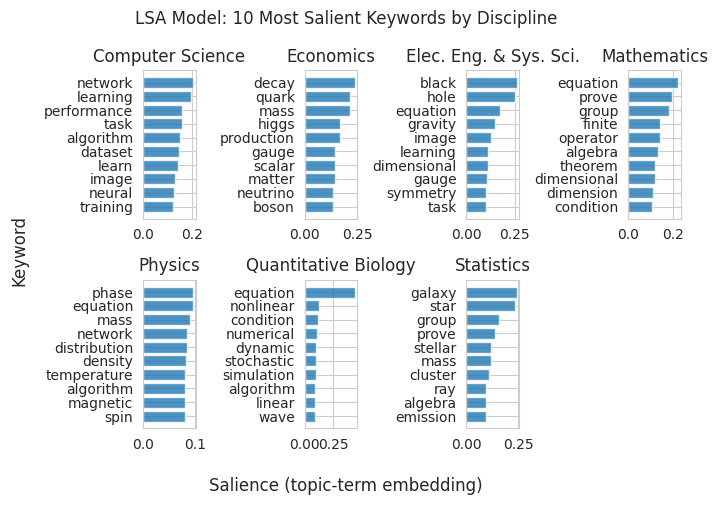

In [ ]:
model_evaluation.keywords_plot(model_key = lsa_key);
plt.savefig(image_path + 'lsa_keywords.png', dpi = 300, bbox_inches = 'tight')

In the faceted bar charts of keywords for the LSA model, the keywords for the more represented disciplines (physics, computer science, and mathematics) seem appropriate. However, the keywords for the underreprented disciplines (statistics, electrical engineering, quantitative biology, and economics) do not make sense intuitively. For example, it is unlikely that economics articles typically discuss quarks, neutrinos, or Higgs-Boson particles, or that statistics articles discuss galaxies and stars.

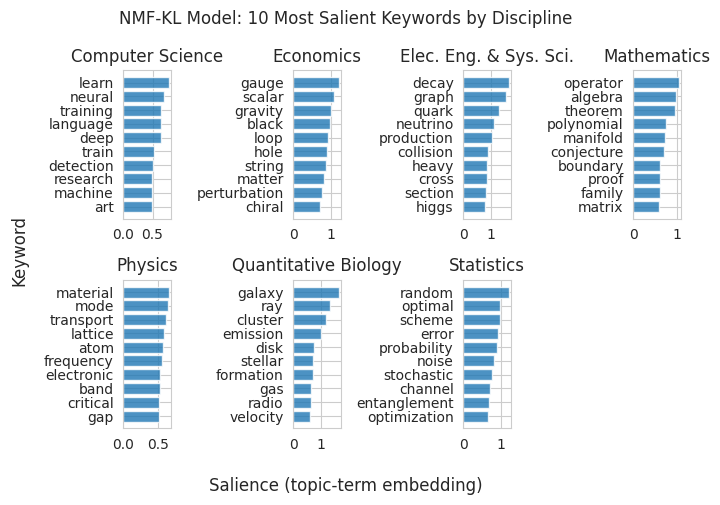

In [ ]:
model_evaluation.keywords_plot(model_key = nmf_kl_key);
plt.savefig(image_path + 'lsa_keywords.png', dpi = 300, bbox_inches = 'tight')

The topic keywords for the NMF-KL model follow largely the same pattern as the LSA model: the major class keywords seem appropriate, but the minor class keywords do not. However, there seems to be an improvement for the statistics topic as, with the exception of "entanglement," its keywords seem germane.

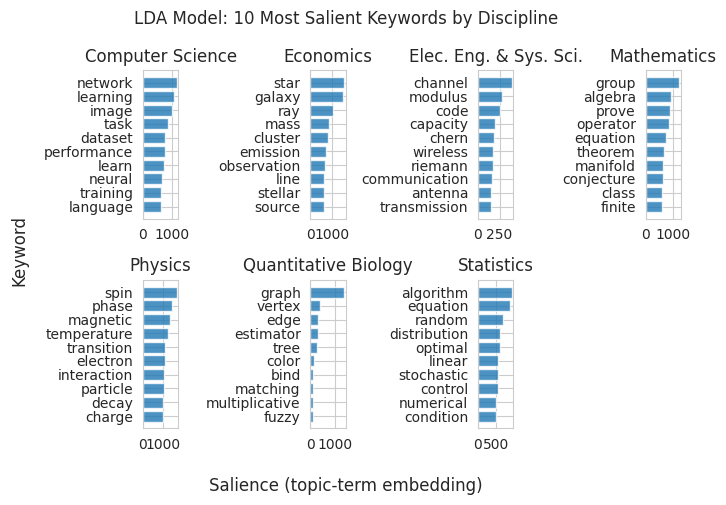

In [ ]:
model_evaluation.keywords_plot(model_key = lda_key);
plt.savefig(image_path + 'lda_keywords.png', dpi = 300, bbox_inches = 'tight')

In the chart for the LDA model, the keywords for all but the two smallest classes (quantitative biology and economics) seem appropriate. It seems quite possible that an electrical engineering or systems science article would discuss communication, antennas, or capacity. This qualitative finding seems to correspond with the LDA's better quantitative performance on the F1 score compared to the other unsupervised models.

## Confusion Matrices

To gain further insight into the models' performance, I examine the confusion matrices for the models

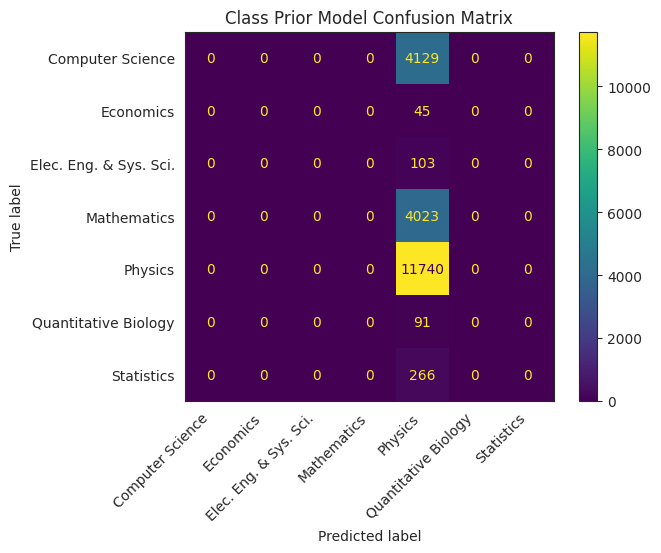

In [ ]:
# Class Prior confusion matrix
cmd = model_evaluation.confusion_matrix_plot(cp_key);
plt.savefig(image_path + 'class_prior_confusion.png', dpi = 300, bbox_inches = 'tight')

The confusion matrix for the class prior model demonstrates why this model performs poorly on the F1 metric, but better on the accuracy metric. It labels all of the articles as physics. Because there are so many physics articles compared to the other disciplines, this achieves accuracy scores around 57%, but F1 scores of only about 10%.

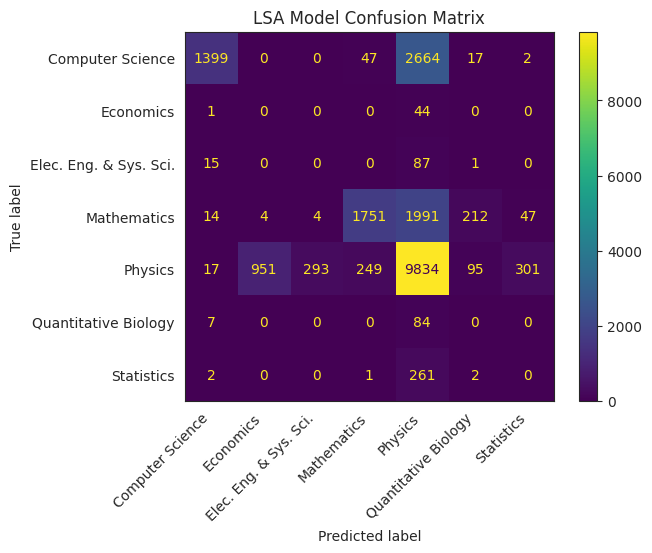

In [ ]:
# LSA confusion matrix
model_evaluation.confusion_matrix_plot(lsa_key);
plt.savefig(image_path + 'lsa_confusion.png', dpi = 300, bbox_inches = 'tight')

In the LSA confusion matrix plot, we see some improvement compared to the class prior model, but the majority of computer science and mathematics articles are being mislabeled as physics.

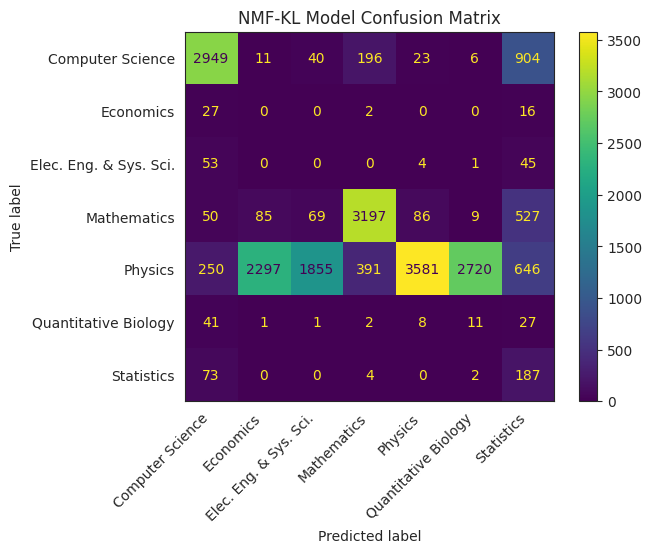

In [ ]:
# NMF-KL confusion matrix
model_evaluation.confusion_matrix_plot(nmf_kl_key);
plt.savefig(image_path + 'nmf_kl_confusion.png', dpi = 300, bbox_inches = 'tight')

The NMF-KL confusion matrix plot above shows improvement in identifying computer science and mathematics articles, but more physics articles are being incorrectly labeled than correctly labeled.

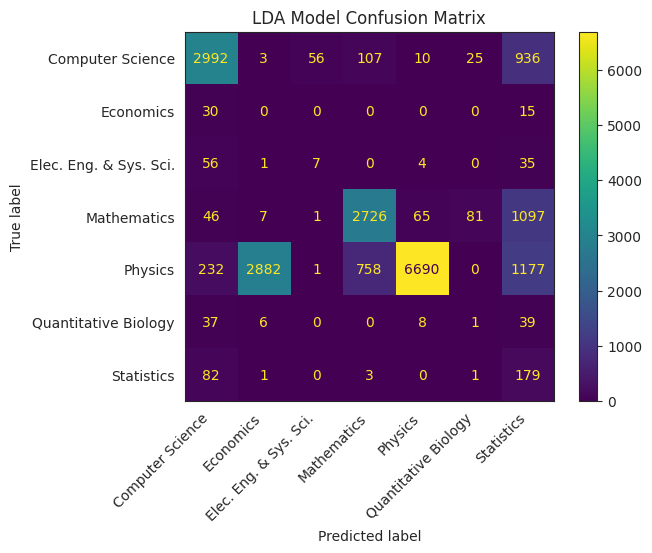

In [ ]:
# LDA confusion matrix
model_evaluation.confusion_matrix_plot(lda_key);
plt.savefig(image_path + 'lda_confusion.png', dpi = 300, bbox_inches = 'tight')

The LDA confusion matrix shows an improvement in labeling the four largest classes (physics, computer science, mathemeatics, and statistics), but it still does poorly in labeling the three smallest classes (economics, quantitative biology, and electrical engineering).

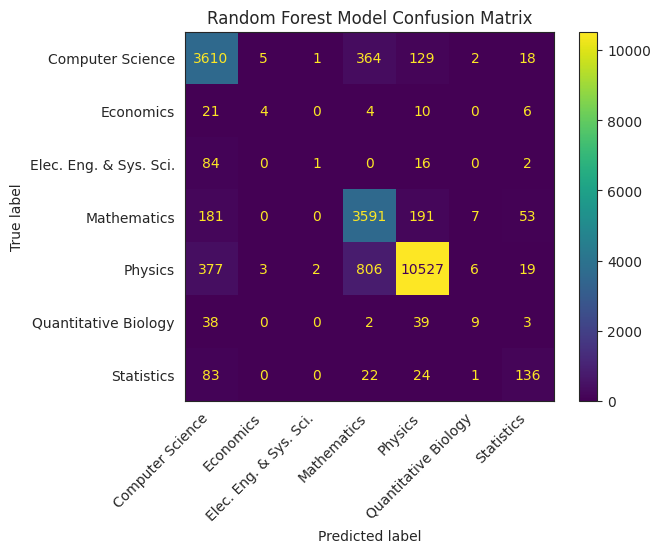

In [ ]:
# Random forest confusion matrix
model_evaluation.confusion_matrix_plot(rf_key);
plt.savefig(image_path + 'rf_confusion.png', dpi = 300, bbox_inches = 'tight')

The random forest confusion matrix plot shows a large improvement in labeling the three largest classes, but not much difference in labeling the smaller classes. However, it is the only model which correctly labeled some of the economics articles (though not many).

## Speed

Next, I examine the models' performance in terms of speed.

### Fit Time

In the confidence interval plot of mean fit time below, the class prior model is unsurprisingly the fastest. The next fastest is the LSA model followed by the NMF and random forest models. The slowest is the LDA model, indicating a trade-off between speed and F1 score (i.e., the harmonic mean of precision and recall).

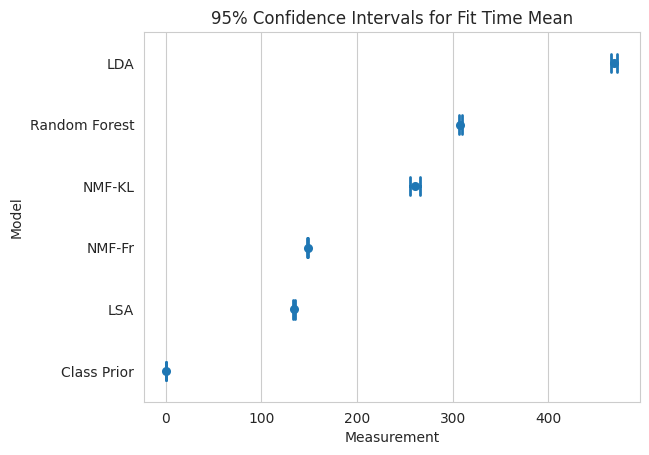

In [ ]:
# Fit time score confidence intervals
model_evaluation.confidence_intervals_plot(metric = 'Fit Time')
plt.savefig(image_path + 'fit_time_ci.png', dpi = 300, bbox_inches = 'tight')

### Prediction Time

In the confidence interval plot of mean prediction times, the class prior and LSA models are the fastest, but the LDA and NMF-KL models are the slowest. The random forest model falls in between. 

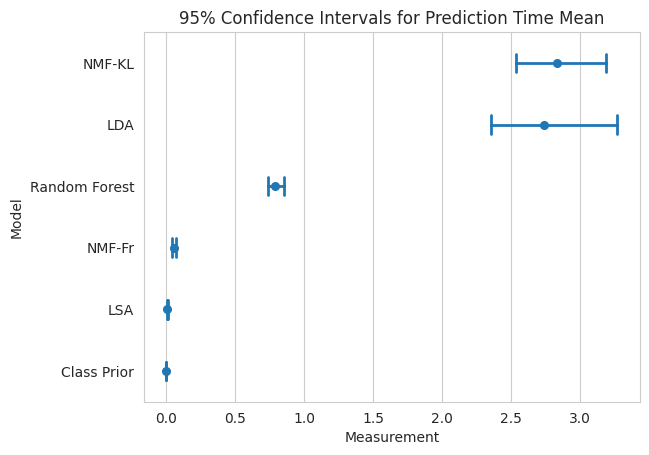

In [ ]:
# Prediction time score confidence intervals
model_evaluation.confidence_intervals_plot(metric = 'Prediction Time');
plt.savefig(image_path + 'predict_time_ci.png', dpi = 300, bbox_inches = 'tight')

## Results and Analysis Summary

This section compared **multiple models' performance** on **multiple metrics** using several **visualizations**. In terms of macro-average F1 score, the random forest model outperformed the unsupervised models by far. Of the unsupervised models, the LDA model performed the best on the F1 metric. Confusion matrices confirmed that all of the models perform poorly in labeling the smallest classes, but the random forest and LDA models did better compared to the other models. Qualitatively, the keywords identified by the LDA model for each topic (i.e., discipline) were more intuitively appropriate than the other unsupervised models, but still nonsensical for the two smallest classes. In terms of speed, the LDA and NMF-KL models had the slowest prediction times, and the LDA model and random forest models had the longest training times. The implications of these findings are discussed in the next section.

# Discussion
In this section, I discuss the project's findings, issues, and future improvements.

## Learning and Takeaways

Based on the above results and analysis, there are several learning points and takeaways.

### Class Imbalance
Despite the use of the more stringent macro-average F1 metric when fitting the models, none of the models were able to completely overcome the stark difference in frequency between the largest classes and the smallest classes in this real-world dataset. However, the supervised random forest model came the closest. This demonstrates the limitations of the use of unsupervised matrix decomposition algorithms on unbalanced data.

### Dimensionality
The unsupervised models performed best on 5,000 or fewer TF-IDF features (less than 2% of the total extracted features). This is a strength of the matrix factorization models. On the other hand, there are limits to how many topics can be modeled when these algorithms are applied in semi-supervised learning tasks because matching the matrix components with the best encoding has factorial time complexity in the number of classes, $O(classes!)$.

### Interpretability
Ostensibly, the strength of unsupervised matrix factorization models is their ability to identify latent topics in unlabeled data. However, these results show the limitations of that capacity. The best unsupervised model was unable to correctly identify qualitatively appropriate top keywords for two out of seven (28.6%) real-world topics. Thus, it is difficult to be confident that the latent topics these unsupervised methods identify correspond to any real categories useful to human beings. 

## Issues
Several issues arose during the project.

### Class Imbalance
Class imbalance had a strongly adverse impact on the unsupervised models' performance, but it would be unrealistic to think that the topics of any set of sampled documents would not be imbalanced. Furthermore, on completely unsupervised tasks with unlabeled data, it will be impossible to use sampling techniques to balance the classes because the classes are unknown.

### Time Complexity
As mentioned, the semi-supervised application of these matrix decomposition algorithms has time complexity factorial in the number of labels. Setting this aside, the best performing unsupervised matrix decomposition algorithm (LDA) was three times slower the fastest. Therefore, even on completely unsupervised tasks (i.e., without searching for optimal encodings), LDA will still be relatively slow.

### Dimensionality
Even though this project used the main disciplines as the target label, there are even more granular distinctions between the texts on the basis of subfields and multiple labels. If these subfields were used as the target or multi-labeling were targeted, the time complexity and class imbalance issues would be even more problematic.

## Future Improvements
There are some possible future improvements that could be made to address the above issues.

### Class Imbalance
Even though class imbalance is a given in real-world data, it would be worth exploring the extent to which it adversely impacts these algorithms. In other words, at what degree of imbalance do these algorithms break down? Can they handle any imbalance?

### Optimization
Parallelization of the semi-supervised encoding search at the implementation level could reduce run times, making the application of these algorithms to larger numbers of topics feasible.

### Neural Networks
Neural network models which can handle high-dimension multilabel-multioutput tasks could be used instead.

# Conclusion

The goal of this project was to compare the performance of unsupervised learning matrix decomposition algorithms in topic modeling real-world, imbalanced academic articles. Of the unsupervised learning models, latent Dirichlet allocation performed best on the macro-average F1 metric as well as qualitatively in terms of keyword identification. However, it was also the slowest to train and one of the slowest on predictions, and it was also outperformed by a supervised random forest model. Future research should explore the extent to which these matrix decomposition algorithms can tolerate class imbalance as well as implementation optimization.

# References

Amor, A., Liu, L., Westermann, M., & Xiao, Y. (n.d.). _User guide._ Sci-Kit Learn. Retrieved April 1, 2025, from [https://scikit-learn.org/stable/user_guide.html](https://scikit-learn.org/stable/user_guide.html)

_Arxiv category taxonomy._ (n.d.) Cornell University. Retrieved March 25, 2025, from [https://arxiv.org/category_taxonomy](https://arxiv.org/category_taxonomy)

Cumming, G., & Finch, S. (2005). Inference by eye: Confidence intervals and how to read pictures of data. _American Psychologist, 60_(2), 170-180. [https://psycnet.apa.org/doi/10.1037/0003-066X.60.2.170](https://psycnet.apa.org/doi/10.1037/0003-066X.60.2.170)

Field, A., Field, Z., & Miles, J. (2012). _Discovering statistics using R._ Sage.

Horn, F., Arras, L., Montavon, G., Müller, K-R, & Samek, W. (2017). Exploring text datasets by visualizing relevant words. Arxiv. [https://doi.org/10.48550/arXiv.1707.05261](https://doi.org/10.48550/arXiv.1707.05261)

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). _An introduction to statistical learning with applications in R_ [2nd ed.]. Springer. [https://www.statlearning.com](https://www.statlearning.com)

Jurafsky, D., & Martin, J. H. (2025). _Speech and language Processing: An introduction to natural language processing, computational linguistics, and speech recognition with language models_ (3rd ed.) [Online manuscript]. [https://web.stanford.edu/~jurafsky/slp3](https://web.stanford.edu/~jurafsky/slp3)

Provost, F. (2000). _Machine learning from imbalanced data sets 101_ (Technical Report WS-00-05). Association for the Advancement of Artificial Intelligence.  [https://aaai.org/papers/ws00-05-001-machine-learning-from-imbalanced-data-sets-101/](https://aaai.org/papers/ws00-05-001-machine-learning-from-imbalanced-data-sets-101/)

Schopf, T. (2024). _Arxiv categories_ [data set]. Hugging Face. [https://huggingface.co/datasets/TimSchopf/arxiv_categories](https://huggingface.co/datasets/TimSchopf/arxiv_categories)

Schopf, T., Blatzheim, A. Machner, N., & Matthes, F. (2024). Efficient few-shot learning for multi-label classification of scientific documents with many classes. In M. Abbas & A. A. Freihat (Eds.), _Proceedings of the 7th International Conference on Natural Language and Speech Processing (ICNLSP 2024)_ (pp. 186-198). Association for Computational Linguistics. [https://aclanthology.org/2024.icnlsp-1.21](https://aclanthology.org/2024.icnlsp-1.21)

van der Maaten, L., & Hinton, G., (2008). Visualizing data using t-SNE. _Journal of Machine Learning Research, 9_(86), 2579-2605. [https://www.jmlr.org/papers/v9/vandermaaten08a.html](https://www.jmlr.org/papers/v9/vandermaaten08a.html)

Verzino, G. (2021, June 27). Why balancing classes is over-hyped: Three reasons you may not need to balance your data set. _Towards Data Science._ [https://towardsdatascience.com/why-balancing-classes-is-over-hyped-e382a8a410f7/](https://towardsdatascience.com/why-balancing-classes-is-over-hyped-e382a8a410f7/)
